# <span style='color:SteelBlue'>P3 - Préparez des données pour un organisme de santé publique (Suite)</span>

![Logo SPF](https://www.paca.ars.sante.fr/sites/default/files/2017-01/spf.jpg)

# <span style='background:blue'>Introduction</span>


Santé publique France propose  **est un établissement public à caractère administratif français, placé sous la tutelle du ministère chargé de la santé**, crée le 1er mai 2016.

___

**Mission**

Nettoyage et exploration des données de l’Agence publique France, afin de déterminer la faisabilité de la création d’un système de suggestion ou d’auto-complétion pour aider leurs usagers à remplir plus efficacement la base de données de l’Agence publique France.

___

**Source des datasets**<br>
[Open Food Facts](https://world.openfoodfacts.org/)<br>
Les variables sont définies [ici](https://world.openfoodfacts.org/data/data-fields.txt)

1 fichier CSV (déjà nettoyé) :
- dataset_openfoodfacts_cleaned.csv
___


**Sommaire**

Importations des librairies utilisées dans ce notebook <br>

Créations des fonctions utilisées dans ce notebook <br>

**Etape 3 : Analyse exploratoire**
- 1/ Analyses univariées
  - a) Evolution des dates de création et modification des produits (lineplot)
  - b) Repartition des Nutri-scores (pie chart)
  - c) Distribution des scores nutritionnels (histogramme et boxplot)
  - d) Recurrence des catégories (barplot)
<br><br>
- 2/ Analyses bivariées
  - a) Analyse de 2 variables quantitatives (Pearson)
  - b) Analyse de 2 variables qualitatives (test du Chi-2)
  - c) Analyse d'1 variable quantitative et une qualitative (Kruskall-Wallis)
<br><br>
- 3/ Analyses multi-variées
  - Analyse multivariée descriptive : l'Analyse en Composantes Principales (ACP)

**Conclusion**

*Remarque : l'étape 1 et 2 de nettoyage sont présentées dans un notebook séparé*

# <span style='background:blue'>Etape 3 : Analyse exploratoire</span>
___

# <span style='background:grey'>Importations des librairies utilisées dans ce notebook</span>

In [1]:
# Librairies
import datetime
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from scipy import stats
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import kruskal
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('Matplotlib    : ' + mpl.__version__)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Scipy         : ' + scipy.__version__)
print('Seaborn       : ' + sns.__version__)
print('Sklearn       : ' + sklearn.__version__)

# Afficher heure lancement
maintenant = datetime.datetime.now().isoformat()
print('\nCode lancé le : ' + maintenant)

Version des librairies utilisées :
Python        : 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]
Matplotlib    : 3.7.2
NumPy         : 1.25.2
Pandas        : 2.1.0
Scipy         : 1.11.2
Seaborn       : 0.12.2
Sklearn       : 1.3.0

Code lancé le : 2023-10-06T14:37:42.141269


Définition de variables communes à tout le notebook

In [2]:
# paramétrage des paramètres d'affichage dans le notebook (pour afficher les définitions des indicateurs)
pd.set_option('display.max_row', 300)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

# Ignorez les avertissements de type FutureWarning pour Seaborn
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Création d'1 palette de couleurs
colors1 = ['Gold', 'MediumPurple', 'DarkOrange', 'LimeGreen', 'Tomato', 'SteelBlue', 'SaddleBrown', 'DeepPink']

# Définit le style de la police pour le titre des graphiques
font_title = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 22}

# Définit le style de la police pour les axes du graphique
font_axe = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 16}

# Seuil de significativité des tests statistiques
seuil_significativite = 0.05

# <span style='background:grey'>Créations des fonctions utilisées dans ce notebook</span>

In [4]:
# #                            CLASSE MODALE
# # ****************************************************************************

def classe_modale(serie, arrondi_nb, bins):
    """
    Fonction qui détermine la classe modale d'une série et le nombre d'élements à l'intérieur.
    
    :param df: series à analyser (df)
    :param nb_classe: nombre de classe à créer (int)
    :param arrondi_nb: nombre de chiffre arrondi après la virgule (int)
    :param bins: nombre de bar (str)
    
    :return classe_modale: classe modale (tuple)
    :return classe_modale: nombre d'élement dans la classe modale (int)
    """
    
    # Utilisez la fonction np.histogram() pour regrouper les données en classes
    hist, bin_edges = np.histogram(serie, bins=bins)
    
    # Trouvez l'indice du bin (classe) ayant la fréquence maximale
    indice_mode = np.argmax(hist)
    
    # Trouver la hauteur du bin (classe) ayant la fréquence maximale
    nb_elements = max(hist)
    
    # Classe modale (arrondi à quelques chiffres après la virgule)
    classe_modale = (round(bin_edges[indice_mode], arrondi_nb), round(bin_edges[indice_mode + 1], arrondi_nb))
    
    # Outputs
    return classe_modale, nb_elements

In [5]:
# #                            STATS DESCRIPTIVES
# # ****************************************************************************

def stats_descriptives(df, col, bins):
    """
    Fonction qui calcule tous les statitiques descriptives du dataframe.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    :param bins: nombre de bar (str)
    
    :return df_stat: data frame des stats descriptives (df)
    """
    
    # Liste des stats
    stat_list = ['moyenne', 'médiane', 'classe modale', 'ecart-type', 'CV', 'skewness', 'kurtosis']  
    
    # Stats descriptives (arrondis après la virgule)
    mean = df[col].mean().__round__(1)
    median = df[col].median().__round__(1)
    mode, nb_element = classe_modale(df[col], arrondi_nb=1, bins=bins)
    std = df[col].std(ddof=0).__round__(1)
    cv = round(std / mean, 2)
    skew = df[col].skew().__round__(2)
    kurtosis = df[col].kurtosis().__round__(1)
    
    # On écrit la phrase de la classe modale
    classe_mod = "{0}: {1} élément(s)".format(mode, nb_element)
    
    # Rassembler dans une liste
    list_stat = [mean, median, classe_mod, std, cv, skew, kurtosis]
    
    # Transformation en data frame (en transposant horizontalement)
    df_stat = pd.DataFrame(list_stat, index=stat_list).T
    
    # Outputs
    return df_stat

In [6]:
# #                            INDEPENDANCE VARIABLES
# # ****************************************************************************

def independance_variables(df, X, Y, largeur, hauteur):
    """
    Procédure qui génère un heatmap pour analyser l'indépendance entre les variables X et Y d'un DataFrame.
    
    :param df: DataFrame à analyser (df)
    :param X: Nom de la première variable (colonne) à utiliser (str)
    :param Y: Nom de la deuxième variable (colonne) à utiliser (str)
    :param largeur: largeur de la heatmap (int)
    :param hauteur: hauteur de la heatmap (int)
    """
    
    # Tableau de contingence : compte les occurrences conjointes de X et Y
    tab_cont = df[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len, margins=True,margins_name="Total")
    
    # Isolation des totaux
    tot_x = tab_cont.loc[:, ["Total"]]
    tot_y = tab_cont.loc[["Total"], :]
    
    # Nombre de lignes
    n = len(df)
    
    # Mesure indépendance : Produit scalaire des 2 vecteurs / nombre de lignes
    indep = tot_x.dot(tot_y) / n
    
    # Remplacement des valeurs nulles du tableau de contingence par 0
    c = tab_cont.fillna(0)
    
    # Mesure statistique de la dépendance entre les variables X et Y
    measure = (c - indep) ** 2 / indep
    
    # Somme de toutes les valeurs dans la table
    xi_n = measure.sum().sum()
    
    # Chaque cellule est divisée par xi_n (normalisation)
    table = measure / xi_n
    
    # Heatmap (table sauf les totaux)
    plt.figure(figsize=(largeur, hauteur))
    heatmap= sns.heatmap(table.iloc[:-1,:-1], cmap="YlGnBu")
    plt.xticks(rotation=90)
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('mesure de contribution à la non-dépendance', labelpad=20, fontdict=font_axe)  
    plt.show()

In [7]:
# #                            RESULTAT SIGNIFICATIVITE
# # ****************************************************************************

def resultat_significativite(p_value, seuil_significativite):
    """
    Procédure qui affiche si l'hypothèse H0 est rejetté ou pas selon la p-value du test statistique.
    
    :param p_value: p-value du test stat (float)
    :param seuil_significativite: seuil de significatité (float)
    """
    
    # Affichage résultat test statistique
    if p_value < seuil_significativite:
        print("p value = {0} < seuil de significativité ({1}) \n=> H0 rejettée : corrélation entre les 2 variables".format(p_value, seuil_significativite))
    
    else:
        print("p value = {0} >= seuil de significativité ({1}) \n=> H0 non rejettée : pas de corrélation entre les 2 variables".format(p_value, seuil_significativite))

In [8]:
# #                            RESULTAT NORMALITE
# # ****************************************************************************

def resultat_normalite(p_value, seuil_significativite):
    """
    Procédure qui affiche si l'hypothèse H0 est rejetté ou pas selon la p-value du test statistique.
    
    :param p_value: p-value du test stat (float)
    :param seuil_significativite: seuil de significatité (float)
    """
    
    # Affichage résultat test statistique
    if p_value < seuil_significativite:
        print("p value = {0} < seuil de significativité ({1}) \n=> H0 rejettée : Les données ne suivent pas la loi normale".format(p_value, seuil_significativite))
    
    else:
        print("p value = {0} >= seuil de significativité ({1}) \n=> H0 non rejettée : les données suivent la loi normale".format(p_value, seuil_significativite))

In [9]:
# #                           EBOULIS VALEURS PROPRES
# # ****************************************************************************

def eboulis_valeurs_propres(acp, features):
    """
    Fonction qui calcule et affiche le diagramme d'éboulis des valeurs propres
    de l'ACP pour aider à déterminer le nombre optimal de composantes principales à conserver. Elle affiche également des informations sur le seuil de Kaiser et les composantes principales retenues.
    
    :param acp: objet ACP préalablement entraîné (sklearn.decomposition.PCA)
    :param features: noms des caractéristiques (variables) originales (list)
    
    :return composante_sup_kaiser_list: numéros de composantes principales à retenir (list)
    :return x_list: index de composantes principales à retenir (list)
    """
    
    # Obtenir les valeurs propre (% inertie totale) et la somme cumulée des inerties
    eigenvalues = (acp.explained_variance_ratio_ * 100).round(2)
    eigenvalues_cum = eigenvalues.cumsum().round()
    
    print("L'ACP a trouvé {0} composantes qui déterminent {1} % du dataframe.".format(len(eigenvalues), eigenvalues_cum[-1]))
    
    # Identifier le seuil de Kaiser et les valeurs propres qui lui sont supérieures
    seuil_kaiser = round(100 / len(eigenvalues), 2)
    composante_sup_kaiser_list = np.where(eigenvalues > seuil_kaiser)[0] + 1
    
    print("\nSoit un seuil de Kaiser = {0}, les composantes principales à conserver sont les composantes {1} à {2}.".format(seuil_kaiser, composante_sup_kaiser_list[0], composante_sup_kaiser_list[-1]))
    
    # Filtrage des valeurs propres retenues (> seuil de Kaiser)
    eigenvalues_retenus = eigenvalues[0:composante_sup_kaiser_list[-1]]
    eigenvalues_cum_retenus = eigenvalues_cum[0:composante_sup_kaiser_list[-1]]
    features_retenus = features[0:composante_sup_kaiser_list[-1]]
    
    # Création axe X des éboulis
    x_list = range(1, composante_sup_kaiser_list[-1] + 1)
    list(x_list)
    
    # Création du diagramme (barplot + lineplot)
    plt.figure(figsize=(10, 6), dpi=80)
    plt.bar(x_list, eigenvalues_retenus, label='Valeur propre individuelle')
    plt.plot(x_list, eigenvalues_cum_retenus, c="red", marker='o', label='Valeur propre cumulée')
    
    # Ajout titre du graphique et des axes, les étiquettes de valeur, la légende
    plt.title("Éboulis des Valeurs Propres", fontdict=font_title)
    plt.xlabel("Composante principale", fontdict=font_axe)
    plt.ylabel("Pourcentage d'inertie", fontdict=font_axe)
    for x, y in zip(x_list, eigenvalues_retenus):
        plt.annotate(f'{y:.2f}%', (x, y), textcoords="offset points", xytext=(0, -15), ha='center', color="white", fontsize=10, fontweight="bold")
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Outputs
    return composante_sup_kaiser_list, x_list

In [10]:
# #                           CORRELATION GRAPH
# # ****************************************************************************

def correlation_graph(pca, x_y, features) :
    """
    Procédure qui affiche un graphe des corrélations entre les composantes principales d'une Analyse en Composantes Principales (ACP).
    
    :param pca: Objet ACP préalablement ajusté (sklearn.decomposition.PCA)
    :param x_y: index du couple de dimensions à afficher (list ou tuple)
    :param features: Noms des caractéristiques (variables) à représenter (list ou tuple).
    """
    
    # Extrait x et y
    x, y=x_y
    
    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))
    
    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):
        
        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )
        
        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
    
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')
    
    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100 * pca.explained_variance_ratio_[x], 1)), fontdict=font_axe)
    plt.ylabel('F{} ({}%)'.format(y+1, round(100 * pca.explained_variance_ratio_[y], 1)), fontdict=font_axe)
    
    # Le Titre du graphique
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1), fontdict=font_title)
    
    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an)) 
    
    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [11]:
# #                           PLAN FACTORIEL
# # ****************************************************************************

def plan_factoriel( X_projected,
                    x_y,
                    pca=None,
                    labels = None,
                    clusters=None,
                    alpha=1,
                    figsize=[10,8],
                    marker="." ):
    """
    Procédure qui affiche la projection des individus sur un plan principal d'une Analyse en Composantes Principales (ACP).
    
    :param X_projected: Matrice des points projetés (np.array, pd.DataFrame, list of list).
    :param x_y: index du couple de dimensions à afficher (list ou tuple)
    
    Paramètres optionnels :
    -----------------------
    :pca: Objet ACP préalablement ajusté (sklearn.decomposition.PCA), permet d'afficher la variance de chaque composante, valeur par défaut = None.
    :labels: Liste ou tuple des labels des individus à projeter, valeur par défaut = None.
    :clusters: Liste ou tuple indiquant à quel cluster appartient chaque individu, valeur par défaut = None.
    :alpha: Valeur de transparence en [0,1] (0=100% transparent, 1=0% transparent), valeur par défaut = 1.
    :figsize: Couple width, height qui définit la taille de la figure en inches, valeur par défaut = [10, 8].
    :marker: Type de marqueur utilisé pour représenter les individus (par exemple, ".", "x"), valeur par défaut = ".".
    """
    
    # Transforme X_projected en np.array
    X_ = np.array(X_projected)
    
    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)
    
    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e
    
    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")
    
    # on définit x et y
    x, y = x_y
    
    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
    
    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)
    
    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100 * pca.explained_variance_ratio_[x])) + " %"
        v2 = str(round(100 * pca.explained_variance_ratio_[y])) + " %"
    else :
        v1 = v2 = ''
    
    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x + 1} {v1}', fontdict=font_axe)
    ax.set_ylabel(f'F{y + 1} {v2}', fontdict=font_axe)
    
    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() * 1.1
    y_max = np.abs(X_[:, y]).max() * 1.1
    
    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)
    
    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0, 0], [-y_max, y_max], color='grey', alpha=0.8)
    
    # Affichage des labels des points
    if len(labels) :
        for i,(_x,_y) in enumerate(X_[:,[x, y]]):
            plt.text(_x, _y + 0.05, labels[i], fontsize='14', ha='center',va='center')
    
    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})", fontdict=font_title)
    plt.show()

# <span style='background:grey'>Importation des données</span>

In [12]:
# Nom du fichier (dataset) nettoyé
csv_nomFichier_clean = "dataset_openfoodfacts_cleaned.csv"

# Importation des noms de col du fichier CSV clean
df_data = pd.read_csv(csv_nomFichier_clean, sep='\t', encoding='utf-8')

# Apercu dataframe
display(df_data.head(3))

,code,created_datetime,last_modified_datetime,product_name,quantity,brands,categories_fr,countries_fr,ingredients_text,serving_size,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_fr,main_category_fr,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,fruits-vegetables-nuts_100g
0,10187319,2017-02-17 10:05:54+00:00,2017-02-17 10:05:54+00:00,Mini Confettis,NaN,Alice Délice,inconnu,France,NaN,NaN,0.0,NaN,0.0,0.0,d,inconnu,inconnu,"A compléter,Informations nutritionnelles compl...",inconnu,1753.0,0.33333,0.8,0.0,0.0,11.40000,87.7,0.9,0.6,0.0100,0.00394,0.0,0.0,0.0,0.0,14.0,45
1,10207260,2017-03-22 17:17:11+00:00,2017-03-22 17:29:17+00:00,Praliné Amande Et Noisette,NaN,Alice Délice,inconnu,France,NaN,NaN,0.0,NaN,0.0,0.0,d,inconnu,inconnu,"A compléter,Informations nutritionnelles compl...",inconnu,2406.0,13.96667,2.9,0.0,0.0,30.03333,50.3,3.9,9.5,0.0030,0.00118,0.0,0.0,0.0,0.0,14.0,45
2,40608754,2012-08-15 09:48:28+00:00,2015-08-09 17:35:31+00:00,"Pepsi, Nouveau goût !",15 cl,Pepsi,"Boissons,Boissons gazeuses,Sodas,Sodas au cola...",France,"Eau gazéifiée, sucre, colorant caramel E150d, ...",150ml,2.0,"E150d - Caramel au sulfite d'ammonium,E338 - A...",0.0,0.0,e,beverages,sweetened beverages,"A vérifier,Complet,Informations nutritionnelle...",sodas,177.0,0.00000,0.0,0.0,0.0,10.40000,10.4,0.0,0.0,0.0254,0.01000,0.0,0.0,0.0,0.0,13.0,45


Jettons un oeil rapide sur les valeurs qui résument les colonnes avec des valeurs numériques. 

In [13]:
df_data.describe()

,code,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,fruits-vegetables-nuts_100g
count,6.17360e+04,61736.00000,61736.00000,61736.00000,61736.00000,61736.00000,61736.00000,61736.00000,61736.00000,61736.00000,61736.00000,61736.00000,61736.00000,61736.00000,61736.00000,6.17360e+04,61736.00000,61736.00000,61736.00000,61736.00000,61736.00000
mean,3.83655e+12,1.36389,0.05170,0.11024,1105.07332,13.73243,5.44657,0.00114,0.00024,25.66858,13.30754,1.77352,7.80031,1.15995,0.43918,4.36250e-06,0.00073,0.01012,0.00075,8.90547,43.18686
std,5.29198e+12,2.34919,0.22477,0.39396,762.98616,17.01546,8.48892,0.07853,0.04395,25.34132,18.87857,3.99771,7.92156,4.11091,1.66050,4.87646e-04,0.03579,0.32392,0.10377,9.17243,16.23748
min,1.00000e+01,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000e+00,0.00000,0.00000,0.00000,-15.00000,25.00000
25%,3.24539e+12,0.00000,0.00000,0.00000,427.00000,1.30000,0.30000,0.00000,0.00000,4.50000,1.00000,0.00000,1.80000,0.08000,0.01969,0.00000e+00,0.00000,0.00000,0.00000,1.00000,25.00000
50%,3.32949e+12,0.00000,0.00000,0.00000,1032.00000,6.90000,2.00000,0.00000,0.00000,14.00000,4.00000,0.00000,6.00000,0.58420,0.19685,0.00000e+00,0.00000,0.00000,0.00000,9.00000,45.00000
75%,3.66060e+12,2.00000,0.00000,0.00000,1636.00000,22.00000,7.50000,0.00000,0.00000,47.00000,17.73333,2.30000,11.00000,1.26000,0.47244,0.00000e+00,0.00000,0.00000,0.00000,16.00000,45.00000
max,3.66111e+14,31.00000,2.00000,5.00000,3761.00000,100.00000,100.00000,17.20000,10.90000,100.00000,100.00000,100.00000,100.00000,100.00000,83.00000,1.20000e-01,7.50000,69.50000,25.00000,45.00000,81.00000


Suite au nettoyage effectué précedemment dans le Notebook, les valeurs médianes, écarts-type et valeurs min et max semblent être cohérentes.


## <span style='background:green'>1/ Analyses univariées</span>

### a) Evolution des dates de création et modification des produits (lineplot)

Nous allons explorer le nombre d'ajout et de modification de produit qui ont été apportées au cours du temps dans le dataset. 

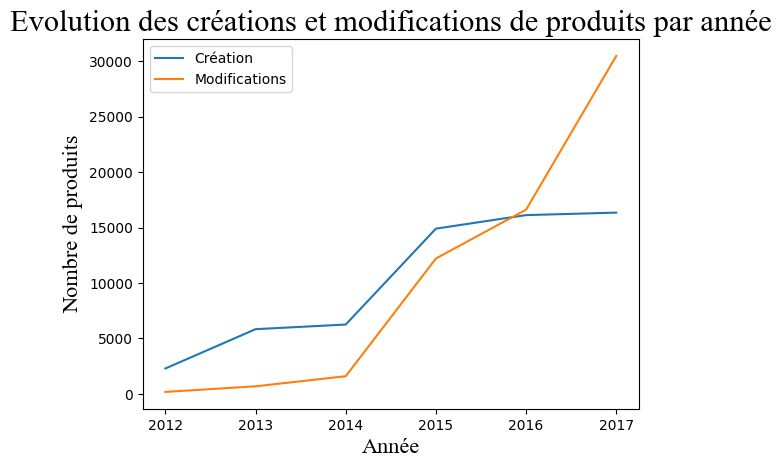

In [14]:
# Transformation en datatime
df_data['created_datetime'] = pd.to_datetime(df_data['created_datetime'])
df_data['last_modified_datetime'] = pd.to_datetime(df_data['last_modified_datetime'])

# Compte les code par année de création et de modification
creation_par_an = df_data['code'].groupby(by=df_data['created_datetime'].dt.year).nunique()

modif_par_an = df_data['code'].groupby(by=df_data['last_modified_datetime'].dt.year).nunique()

# Evolution des créations et des modifications
plt.plot(creation_par_an, label="Création")
plt.plot(modif_par_an, label="Modifications")

# Ajout Titre graphique, titre des axes, legende
plt.title("Evolution des créations et modifications de produits par année", 
        fontdict=font_title)
plt.xlabel("Année", fontdict=font_axe)
plt.ylabel("Nombre de produits", fontdict=font_axe)
plt.legend()
plt.show()

**Création**
<br>Nous remarquons un inflexion de la courbe des créations qui ont augmentées en 2014. Cette courbe stagne depuis 2015. 

**Modifications**
<br>Nous remarquons une première inflexion de la courbe des modifications qui ont augmentées nettement à partir de 2014. Une deuxième inflexion est constatée en 2016. 

In [15]:
# Calcul pourcentage des produits modifiées après leur création
ratio_produit_modified = round((df_data[df_data['last_modified_datetime'] > df_data['created_datetime']].shape[0] / df_data.shape[0]) * 100, 1)

# Affichage
print("{0} % des produits ont été modifiés au moins 1 fois depuis leur création.".format(ratio_produit_modified))

88.1 % des produits ont été modifiés au moins 1 fois depuis leur création.


### b) Repartition des Nutri-scores (pie chart)

Nous allons explorer la répartition des nutriscore pour chacune des 5 letttres possibles. 

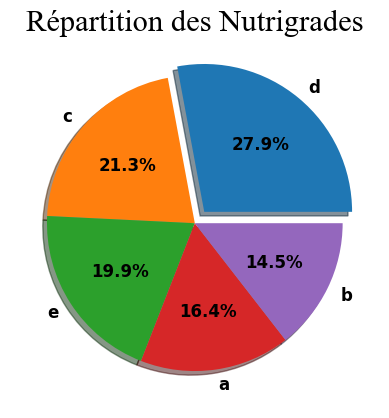

In [16]:
# Compte les code par lettre de nutriscore (ordre décroissant)
nutriscore = df_data.groupby(by='nutrition_grade_fr')['code'].nunique().sort_values(ascending=False)

# Vecteur pour séparer un bout du camembert
explodes = np.zeros(5)
explodes[0] = .1

# Diagramme camembert (avec de l'ombre, une part séparée, un format d'affichage des étiquettes de données)
plt.pie(nutriscore, labels=nutriscore.index, 
        shadow=True,
        explode=explodes,
        autopct='%1.1f%%',
        textprops=dict(color="black",size=12, weight="bold"))

# Ajout du titre
plt.title("Répartition des Nutrigrades", fontdict=font_title)
plt.show()

Nous remarquons que les lettre "c" et "d" représentent quasiment la moitité des aliments (49,2%). La lettre la moins présente est la lettre "b". 

### c) Distribution du score nutritionnel (histogramme et boxplot)

Nous allons explorer la distribution du score nutritionnel sous forme de boxplot. 

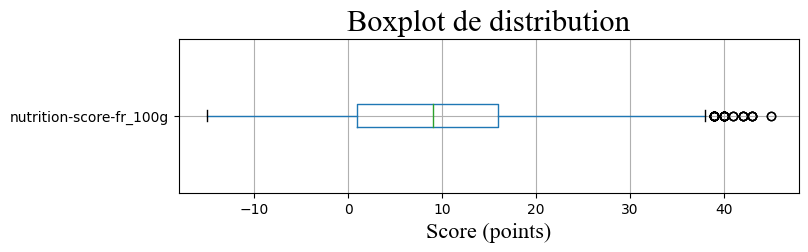

In [17]:
# Affichage boite à moustache
plt.figure(figsize=(8, 2))
df_data.boxplot(column="nutrition-score-fr_100g", vert=False, labels=["nutrition-score-fr_100g"], showfliers=True)

# Ajout du titre
plt.title('Boxplot de distribution', fontdict=font_title)
plt.xlabel("Score (points)", fontdict=font_axe)
plt.show()

Le **score nutritionnel** calculé dans la nouvelle méthode de 2023 grâce aux: 

- Eléments « défavorables » : La somme des points attribués pour ces éléments pouvant varier de 0 à 55 points
<br><br>
- Eléments « favorables » :  La somme des points attribués pour ces éléments pouvant varier de 0 à 17 points

=> **Le score nutritionnel en France avec la méthode de calcul de 2023 doit être compris entre -17 et +55** 

Source : [NUTRI-SCORE Questions & Réponses de Santé publique France](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjqxJ7p8KyBAxXDUqQEHRpiBeoQFnoECBUQAQ&url=https%3A%2F%2Fwww.santepubliquefrance.fr%2Fmedia%2Ffiles%2F02-determinants-de-sante%2Fnutrition-et-activite-physique%2Fnutri-score%2Ffaq_fr&usg=AOvVaw0WQv0l_eVKgvmWEjnUAVZC&opi=89978449)

_____

**Tous les outliers sont donc des valeurs atypiques mais pas abérrantes.**

Nous allons explorer la distribution du score nutritionnel sous forme d'histogramme. 

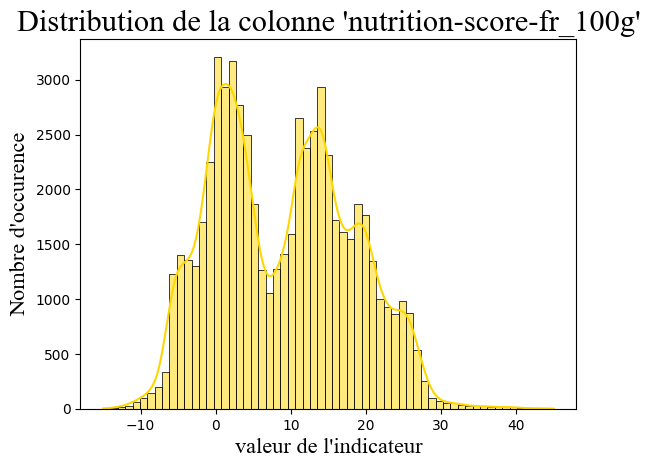

In [18]:
# Affichage Courbe histogramme
sns.histplot(df_data["nutrition-score-fr_100g"], kde=True, color=colors1[0], bins=61)

# Ajout du titre du graphique, des axes X et Y
plt.title("Distribution de la colonne '{0}'".format("nutrition-score-fr_100g"), fontdict=font_title)
plt.xlabel("valeur de l'indicateur", fontdict=font_axe)
plt.ylabel("Nombre d'occurence", fontdict=font_axe)
plt.show()

Nous allons également appiquer une série de statistiques descriptives sur ces données. 

In [19]:
# Calcul des stats descriptives
df_stat = stats_descriptives(df_data, "nutrition-score-fr_100g", bins=61)
display(df_stat)

,moyenne,médiane,classe modale,ecart-type,CV,skewness,kurtosis
0,8.9,9.0,"(-0.2, 0.7): 3210 élément(s)",9.2,1.03,0.22,-0.8


Le terme **quantile** est une mesure statistique utilisée pour diviser un ensemble de données en sous-groupes de manière égale ou proportionnelle en fonction de leur position dans la distribution des données. Les quantiles sont couramment utilisés pour comprendre la répartition des valeurs dans un ensemble de données et pour identifier les valeurs atypiques ou extrêmes. Les quantiles couramment utilisés comprennent :
- Le **quantile médian** (Q2), qui divise l'ensemble de données en 2 parties égales, où la moitié des valeurs sont inférieures au quantile médian et l'autre moitié sont supérieures. Il est égal à la médiane.
  
- Le **premier quartile** (Q1) : Le point qui divise les 25 % inférieurs des données.

- Le **troisième quartile** (Q3) : Le point qui divise les 25 % supérieurs des données.

- les **déciles** : Les quantiles qui divisent les données en 10 parties égales (decile 1, decile 2, etc.).

- Les **centiles** : Les quantiles qui divisent les données en 100 parties égales (centile 1, centile 2, etc.).


In [20]:
# Calculer le premier quartile (Q1)
q1 = np.percentile(df_data["nutrition-score-fr_100g"], 25)

# Calculer le troisième quartile (Q3)
q3 = np.percentile(df_data["nutrition-score-fr_100g"], 75)

# Calculer les déciles
deciles = np.percentile(df_data["nutrition-score-fr_100g"], [10, 20, 30, 40, 50, 60, 70, 80, 90])

# Afficher les résultats
print("Premier quartile (Q1) :", q1)
print("Troisième quartile (Q3) :", q3)
print("Déciles :", deciles)

Premier quartile (Q1) : 1.0
Troisième quartile (Q3) : 16.0
Déciles : [-2.  0.  2.  4.  9. 12. 14. 18. 21.]


Résumé de la distribution du score nutrionnel : 

- **Aspect** : distribution **bimodale** => 2 zones de fortes concentrations (autour de 0 / entre 10 et 20).
  
- **Tendance centrale** : La **moyenne** et la **médiane** sont proches autour du score 9.
  
- **Dispersion** : les données forment un groupe très hétérogène (CV > 15% & > 100%).
  
- **Forme** : les données sont étalées à droite (skewness>0) et les observations sont plus aplaties que la loi normale (kurtosis<0).

### d) Recurrence des catégories (barplot)

Nous allons explorer la récurrence des categories dans 'pnns_groups_1'. 

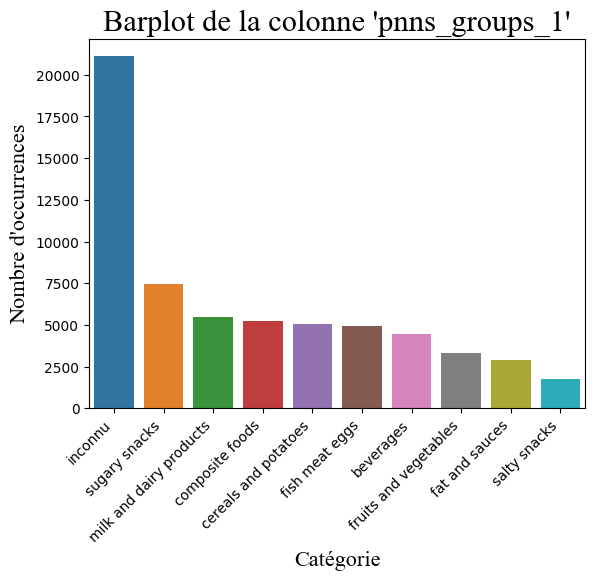

In [21]:
# Compter les occurrences de chaque catégorie dans la colonne 'pnns_groups_1'
counts = df_data['pnns_groups_1'].value_counts()

# Créer un barplot avec Seaborn
sns.barplot(x=counts.index, y=counts.values)

# Ajout du titre du graphique, des axes X et Y
plt.title("Barplot de la colonne 'pnns_groups_1'", fontdict=font_title)
plt.xlabel('Catégorie', fontdict=font_axe)
plt.ylabel('Nombre d\'occurrences', fontdict=font_axe)
plt.gca().set_xticklabels(counts.index, rotation=45, ha='right')
plt.show()

La catégorie "inconnu" est la plus représentée. 

Nous allons explorer la récurrence des categories dans 'pnns_groups_2'. 

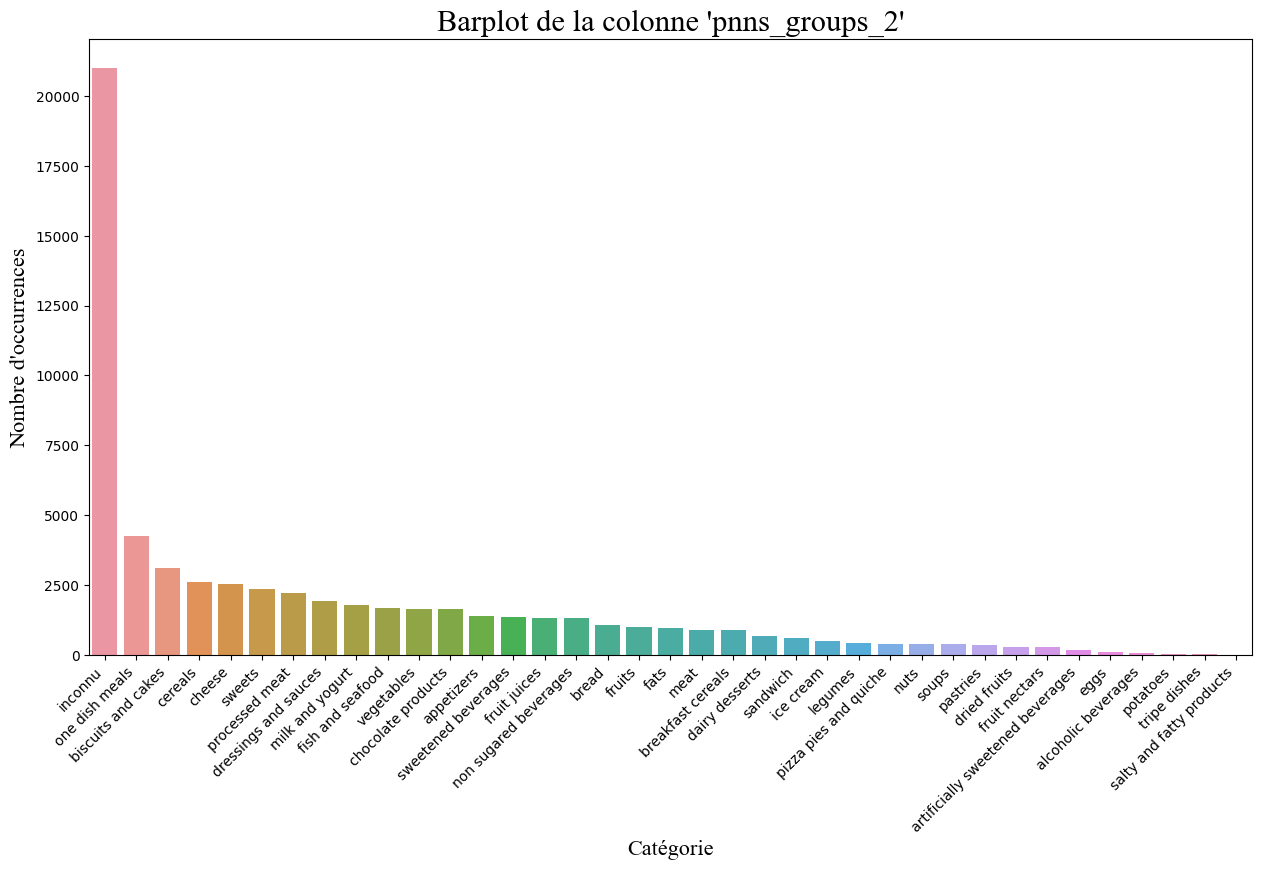

In [22]:
# Compter les occurrences de chaque catégorie dans la colonne 'pnns_groups_2'
counts = df_data['pnns_groups_2'].value_counts()

# Créer un barplot avec Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(x=counts.index, y=counts.values)

# Ajout du titre du graphique, des axes X et Y
plt.title("Barplot de la colonne 'pnns_groups_2'", fontdict=font_title)
plt.xlabel('Catégorie', fontdict=font_axe)
plt.ylabel('Nombre d\'occurrences', fontdict=font_axe)
plt.gca().set_xticklabels(counts.index, rotation=45, ha='right')
plt.show()

La catégorie "inconnu" est la plus représentée. 

## <span style='background:green'>2/ Analyses bivariées</span>

### a) Analyse de 2 variables quantitatives (Pearson)

#### Matrice de corrélation

Nous affichons une matrice de corrélation de toutes las variables quantitatives de notre dataset pour pouvoir détecter les corrélations linéaires les plus visibles grâce aux coefficients de corrélation de Pearson. 

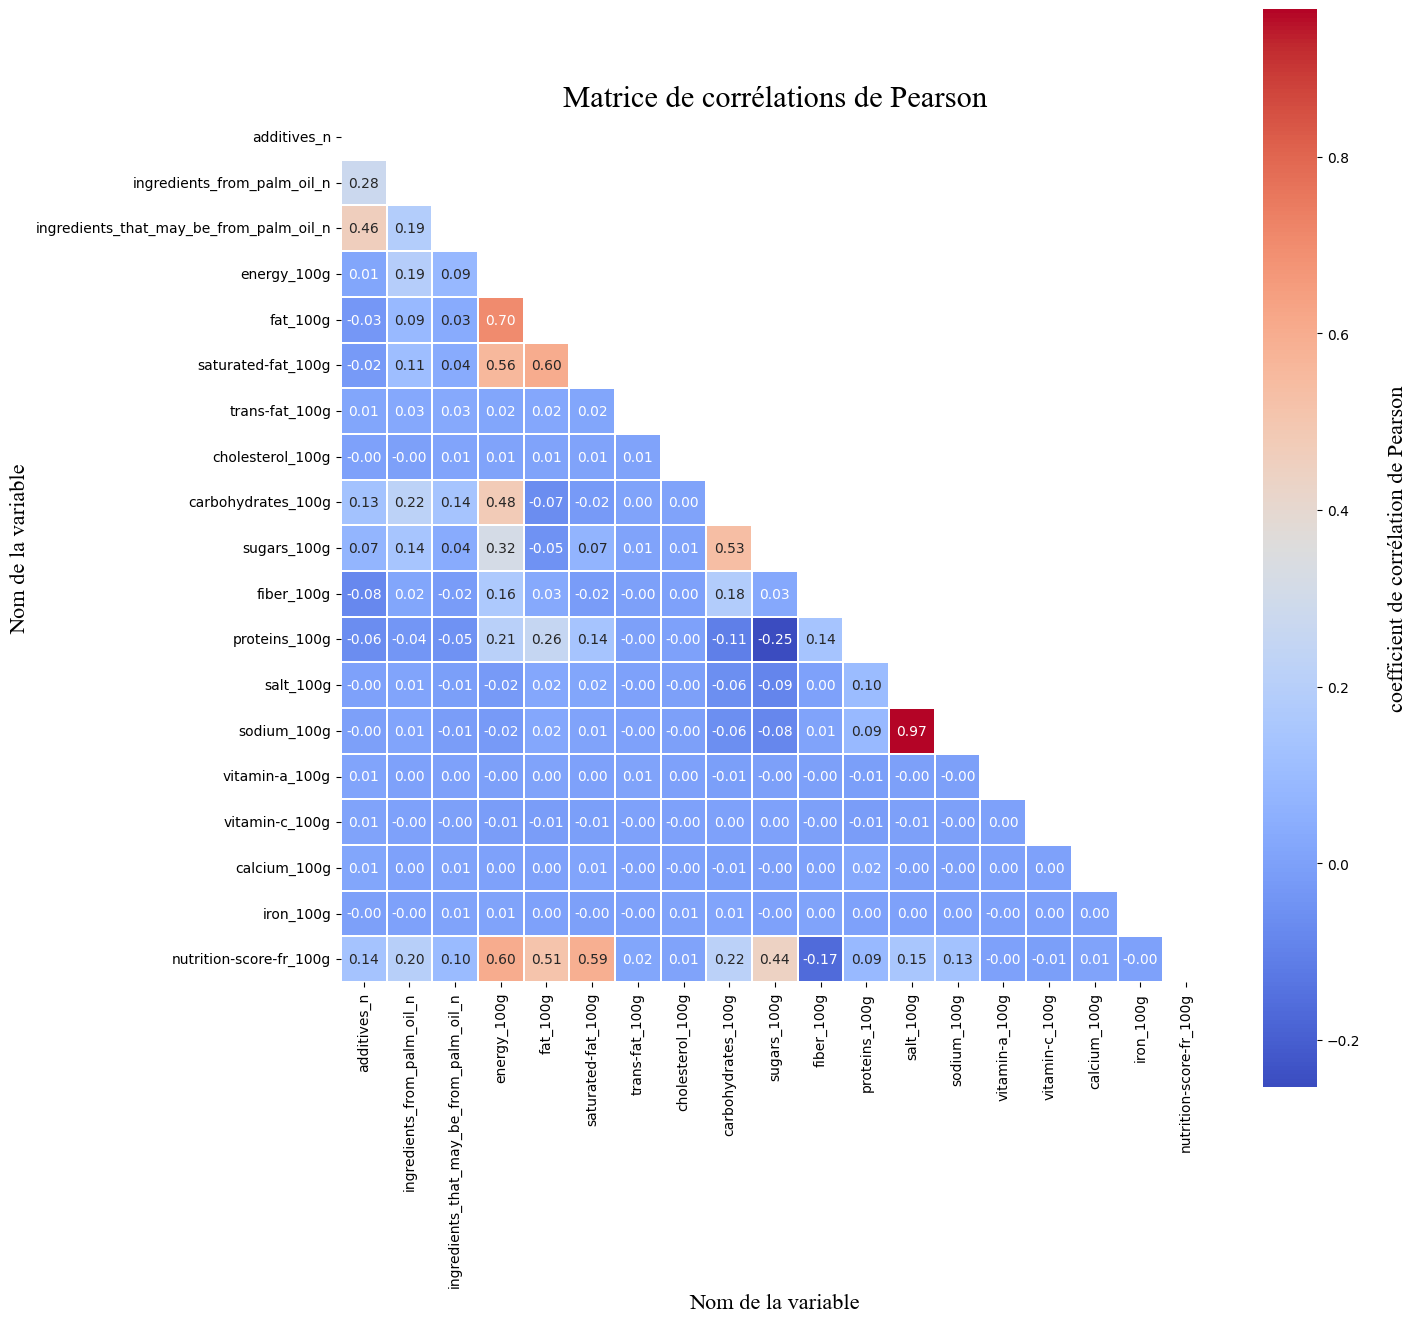

In [23]:
# Sélection des colonnes comportant des valeurs quantitatives
df_data_float = df_data.select_dtypes(include=['float64', 'float32'])

# Matrice des corrélations
corr_mat = df_data_float.corr()

# Créer un masque pour masquer les valeurs au-dessus de la diagonale
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# heatmap
fig = plt.figure(figsize=(14,14))
heatmap = sns.heatmap(corr_mat, square=True, linewidths=0.01, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)

# Ajout du titre du graphique, des axes et de la colorbar
plt.title("Matrice de corrélations de Pearson", fontdict=font_title)
plt.xlabel("Nom de la variable", fontdict=font_axe)
plt.ylabel("Nom de la variable", fontdict=font_axe)
cbar = heatmap.collections[0].colorbar
cbar.set_label('coefficient de corrélation de Pearson', labelpad=20, fontdict=font_axe)  
plt.show()

Nous remarquons une corrélation linéaire forte (r > 0.95) :
- Corrélation entre le sel et le sodium (r = 0.97)

Nous remarquons quelques corrélations linéaires apparentes (r > 0.60) :
- Corrélation entre l'énergie et les lipides (p = 0.70)
- Corrélation entre l'énergie et le score nutritionnel (p = 0.60)
- Corrélation entre les lipides et les acides gras saturés (p = 0.60)

Bien que les corrélations sel/sodium et lipides/acides gras saturés semblent tout à fait logiques, les 2 autres sont moins évidents à mettre en avant. 

Nous allons donc nous interreser à la corrélation utile la plus probante : **corrélation énergie / lipide**.

#### Régression linéaire (Pearson)

Nous allons d'abord afficher la distribution de "fat_100g" et "energy_100g" pour visualiser les outliers. Et connaitre Q3 pour pouvoir identifier les outliers. 

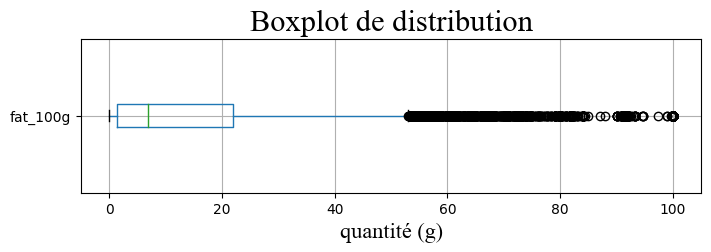

Troisième quartile (Q3) : 22.0


In [24]:
# Affichage boite à moustache
plt.figure(figsize=(8, 2))
df_data.boxplot(column="fat_100g", vert=False, labels=["fat_100g"], showfliers=True)

# Ajout du titre
plt.title('Boxplot de distribution', fontdict=font_title)
plt.xlabel("quantité (g)", fontdict=font_axe)
plt.show()

# Calculer le troisième quartile (Q3)
q3_fat = np.percentile(df_data["fat_100g"], 75)
print("Troisième quartile (Q3) :", q3_fat)

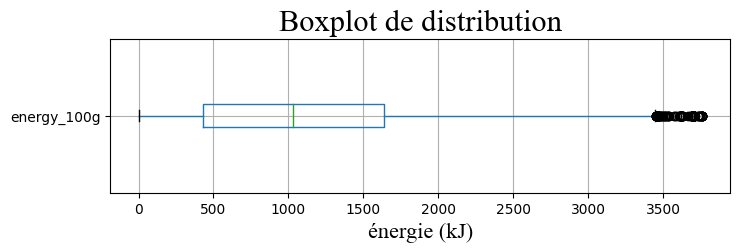

Troisième quartile (Q3) : 1636.0


In [25]:
# Affichage boite à moustache
plt.figure(figsize=(8, 2))
df_data.boxplot(column="energy_100g", vert=False, labels=["energy_100g"], showfliers=True)

# Ajout du titre
plt.title('Boxplot de distribution', fontdict=font_title)
plt.xlabel("énergie (kJ)", fontdict=font_axe)
plt.show()

# Calculer le troisième quartile (Q3)
q3_energy = np.percentile(df_data["energy_100g"], 75)
print("Troisième quartile (Q3) :", q3_energy)

#### Regression linéaire avec les outliers

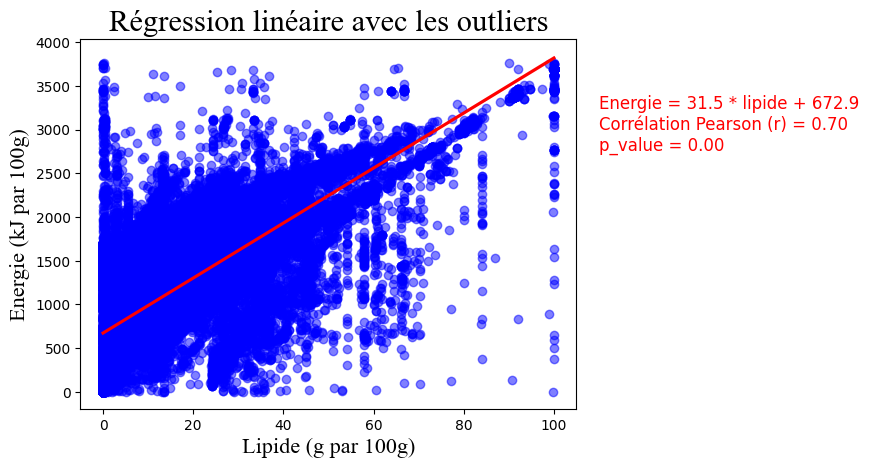

In [26]:
# Calcul de la régression linéaire
slope, intercept, r_value, p_value, std_err = stats.linregress(df_data["fat_100g"], df_data["energy_100g"])

# Textes de l'équation, la corrélation et la p_value
equation_text = f"Energie = {slope:.1f} * lipide + {intercept:.1f}"
correlation_text = f"Corrélation Pearson (r) = {r_value:.2f}"
p_value_text = f"p_value = {p_value:.2f}"
text_pour_graph = equation_text + "\n" + correlation_text + "\n" + p_value_text

# Créez un scatter plot avec une ligne de régression en rouge
sns.regplot(x=df_data["fat_100g"], y=df_data["energy_100g"], scatter_kws={'color': 'blue', 'alpha': 0.5}, line_kws={'color': 'red'})

# Ajout texte, titre graphique, titre des axess X et Y
plt.text(df_data["fat_100g"].max() + 10, df_data["energy_100g"].max() - 1000,
        text_pour_graph, fontsize=12, color='red')
plt.title("Régression linéaire avec les outliers", fontdict=font_title)
plt.xlabel('Lipide (g par 100g)', fontdict=font_axe)
plt.ylabel('Energie (kJ par 100g)', fontdict=font_axe)
plt.show()

On veut savoir si ces 2 variables sont réellement corrélées ou pas. On doit donc réaliser un test d'hypothèse :

**Hypothèse nulle (H0) : Pas de corrélation entre les 2 variables.**

Hypothèse alternative (HA) : Corrélation entre les 2 variables.

In [27]:
# Affichage résultat test statistique
resultat_significativite(p_value, seuil_significativite)

p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : corrélation entre les 2 variables


**Il existe une corrélation positive entre la quantité de lipide et la quantité d'énergie (r=0.70)**

#### Regression linéaire sans les outliers

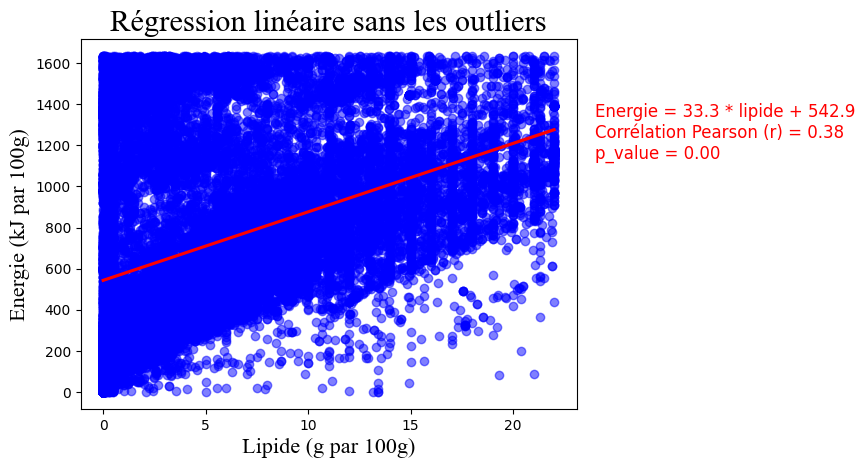

In [28]:
# Suppression des outliers
df_data_clean_fat = df_data.loc[df_data["fat_100g"] <= q3_fat, :]
df_data_clean_fat_energy = df_data_clean_fat.loc[df_data_clean_fat["energy_100g"] <= q3_energy]

# Calcul de la régression linéaire
slope, intercept, r_value, p_value, std_err = stats.linregress(df_data_clean_fat_energy["fat_100g"], df_data_clean_fat_energy["energy_100g"])

# Textes de l'équation, la corrélation et la p_value
equation_text = f"Energie = {slope:.1f} * lipide + {intercept:.1f}"
correlation_text = f"Corrélation Pearson (r) = {r_value:.2f}"
p_value_text = f"p_value = {p_value:.2f}"
text_pour_graph = equation_text + "\n" + correlation_text + "\n" + p_value_text

# Créez un scatter plot avec une ligne de régression en rouge
sns.regplot(x=df_data_clean_fat_energy["fat_100g"], y=df_data_clean_fat_energy["energy_100g"], scatter_kws={'color': 'blue', 'alpha': 0.5}, line_kws={'color': 'red'})

# Ajout texte, titre graphique, titre des axess X et Y
plt.text(df_data_clean_fat_energy["fat_100g"].max() + 2, df_data_clean_fat_energy["energy_100g"].max() - 500,
        text_pour_graph, fontsize=12, color='red')
plt.title("Régression linéaire sans les outliers", fontdict=font_title)
plt.xlabel('Lipide (g par 100g)', fontdict=font_axe)
plt.ylabel('Energie (kJ par 100g)', fontdict=font_axe)
plt.show()

On veut savoir si ces 2 variables sont réellement corrélées ou pas. On doit donc réaliser un test d'hypothèse :

**Hypothèse nulle (H0) : Pas de corrélation entre les 2 variables.**

Hypothèse alternative (HA) : Corrélation entre les 2 variables.

In [29]:
# Affichage résultat test statistique
resultat_significativite(p_value, seuil_significativite)

p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : corrélation entre les 2 variables


**Il existe une corrélation positive entre la quantité de lipide et la quantité d'énergie (r=0.38)**

### b) Analyse de 2 variables qualitatives (test du Chi-2)

Nous allons vérifier si les 2 variables des catégories d'aliment sont corrélées entre elles. Puis nous en ferons de même avec chacune de ces 2 variables et celle du nutri-score.

#### - Independance des variables "pnns_group_1" et "pnns_group_2"

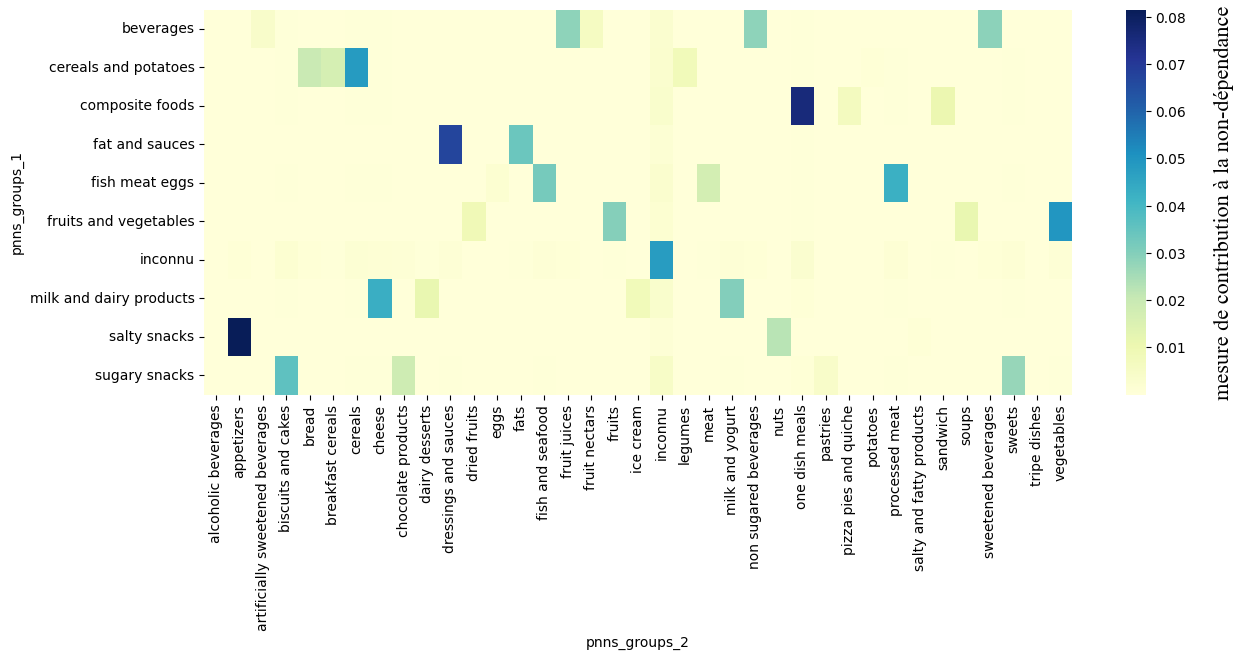

Test du chi-deux : Chi² = 555624.00, p-value = 0.00


In [30]:
# Colonnes d'intérêt
X = "pnns_groups_1"
Y = "pnns_groups_2"

# Affichage heatmap des mesures de contribution à la non-dépendance
independance_variables(df_data, X, Y, largeur=14, hauteur=5)

# Tableau de contingence : compte les occurrences conjointes de X et Y
tab_cont = pd.crosstab(df_data[X], df_data[Y])

# Test du chi-2
chi2, p_value, dof, expected = chi2_contingency(tab_cont)

# Affichage résultats
print(f"Test du chi-deux : Chi² = {chi2:.2f}, p-value = {p_value:.2f}")

On veut savoir si ces 2 variables sont réellement corrélées ou pas. On doit donc réaliser un test d'hypothèse :

**Hypothèse nulle (H0) : Pas de corrélation entre les 2 variables.**

Hypothèse alternative (HA) : Corrélation entre les 2 variables.

In [31]:
# Affichage résultat test statistique
resultat_significativite(p_value, seuil_significativite)

p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : corrélation entre les 2 variables


**Il existe une corrélation entre variables "pnns_group_1" et "pnns_group_2"**

Il semblerait que les "appéritifs" soient souvent des "snac salés", que les "vinaigrettes et sauces" soient souvent "huiles et sauces", que les "repas en un seul plat" soient souvent "aliments composites". 

#### - Independance variables "nutrition_grade_fr" et "pnns_group_1"

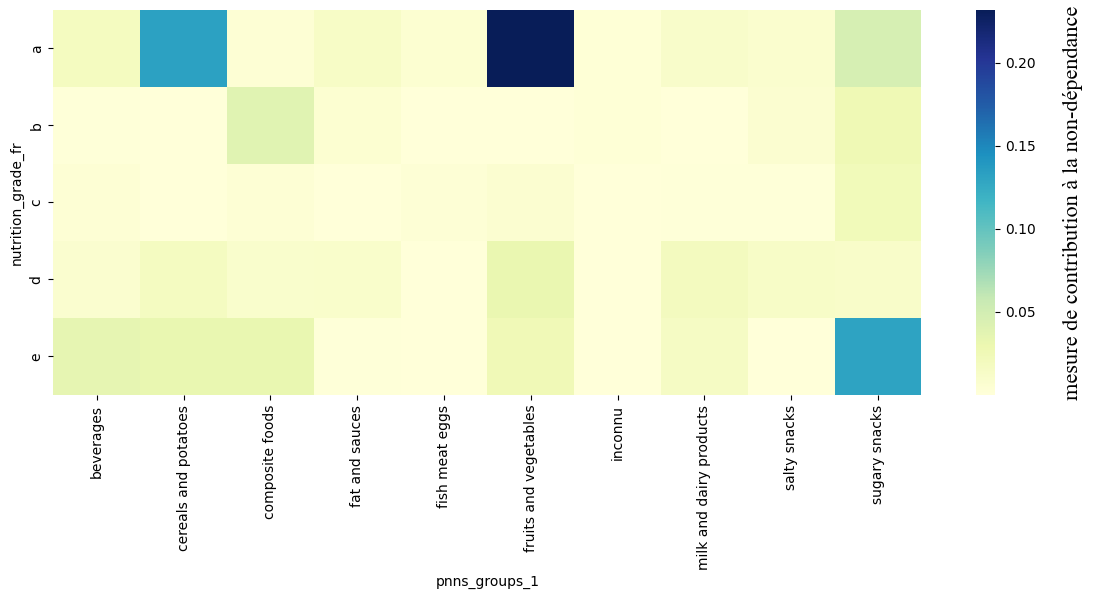

Test du chi-deux : Chi² = 24079.63, p-value = 0.00


In [32]:
# Colonnes d'intérêt
X = "nutrition_grade_fr"
Y = "pnns_groups_1"

# Affichage heatmap des mesures de contribution à la non-dépendance
independance_variables(df_data, X, Y, largeur=14, hauteur=5)

# Tableau de contingence : compte les occurrences conjointes de X et Y
tab_cont = pd.crosstab(df_data[X], df_data[Y])

# Test du chi-2
chi2, p_value, dof, expected = chi2_contingency(tab_cont)

# Affichage résultats
print(f"Test du chi-deux : Chi² = {chi2:.2f}, p-value = {p_value:.2f}")

On veut savoir si ces 2 variables sont réellement corrélées ou pas. On doit donc réaliser un test d'hypothèse :

**Hypothèse nulle (H0) : Pas de corrélation entre les 2 variables.**

Hypothèse alternative (HA) : Corrélation entre les 2 variables.

In [33]:
# Affichage résultat test statistique
resultat_significativite(p_value, seuil_significativite)

p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : corrélation entre les 2 variables


**Il existe une corrélation entre variables "nutrition_grade_fr" et "pnns_group_1"**

Il semblerait que les aliments avec le nutri-score A soient souvent des "fruits et légumes" et des "céréales et pomme de terre". Les aliments avec le nutri-score E soient souvent des "snacs sucrés".

#### - Independance variables "nutrition_grade_fr" et "pnns_group_2"

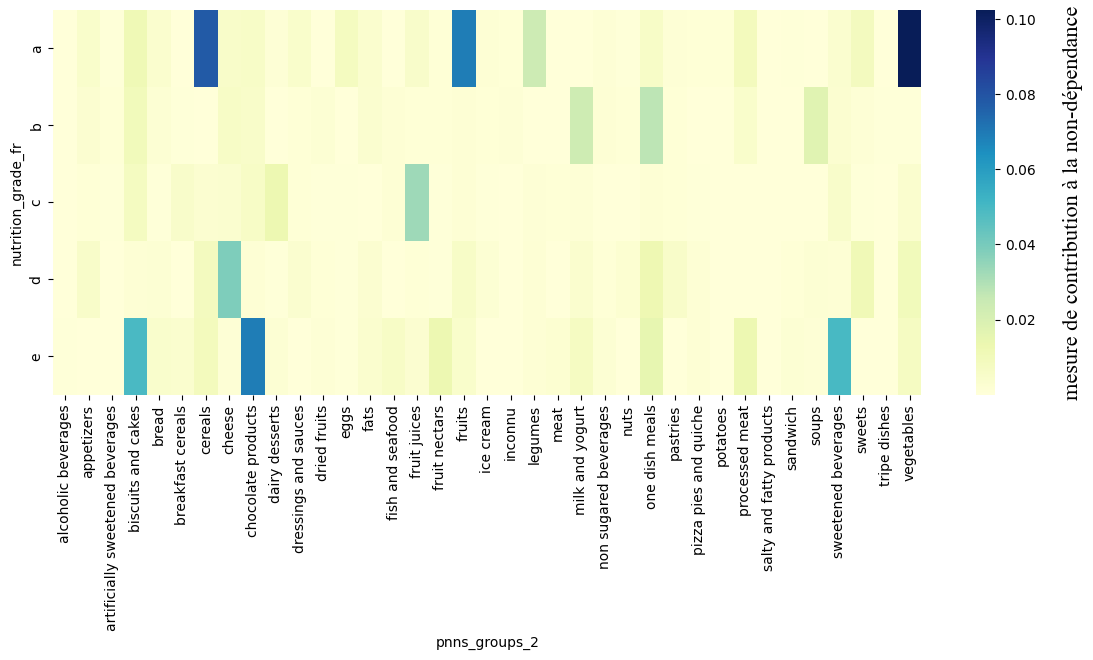

Test du chi-deux : Chi² = 40894.46, p-value = 0.00


In [34]:
# Colonnes d'intérêt
X = "nutrition_grade_fr"
Y = "pnns_groups_2"

# Affichage heatmap des mesures de contribution à la non-dépendance
independance_variables(df_data, X, Y, largeur=14, hauteur=5)

# Tableau de contingence : compte les occurrences conjointes de X et Y
tab_cont = pd.crosstab(df_data[X], df_data[Y])

# Test du chi-2
chi2, p_value, dof, expected = chi2_contingency(tab_cont)

# Affichage résultats
print(f"Test du chi-deux : Chi² = {chi2:.2f}, p-value = {p_value:.2f}")

On veut savoir si ces 2 variables sont réellement corrélées ou pas. On doit donc réaliser un test d'hypothèse :

**Hypothèse nulle (H0) : Pas de corrélation entre les 2 variables.**

Hypothèse alternative (HA) : Corrélation entre les 2 variables.

In [35]:
# Affichage résultat test statistique
resultat_significativite(p_value, seuil_significativite)

p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : corrélation entre les 2 variables


**Il existe une corrélation entre variables "nutrition_grade_fr" et "pnns_group_2"**

Il semblerait que les aliments avec le nutri-score : 
- A soient souvent des "céréales", des "fruits" et des "légumes".
- C soient souvent des "jus de fruits".
- D soient souvent des "fromages".
- E soient souvent des "biscuits et gateaux", des "produits chocolatés" et des "boissons sucrées".

### c) Analyse d'1 variable quantitative et une qualitative (Kruskall-Wallis)

#### Normalité des données

Tout d'abord nous devons vérifier la normalité des données quantitatives avec le test de Shapiro-Wilk.

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


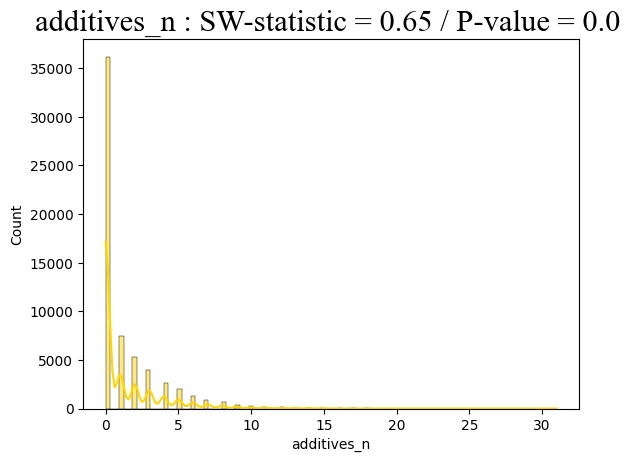

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


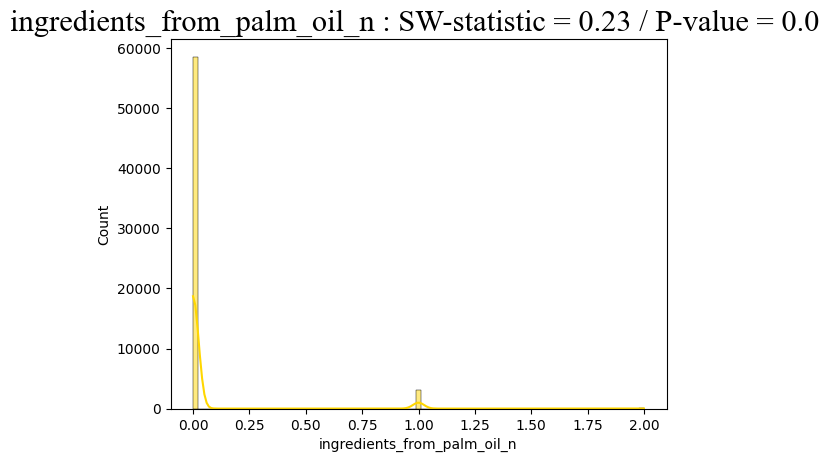

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


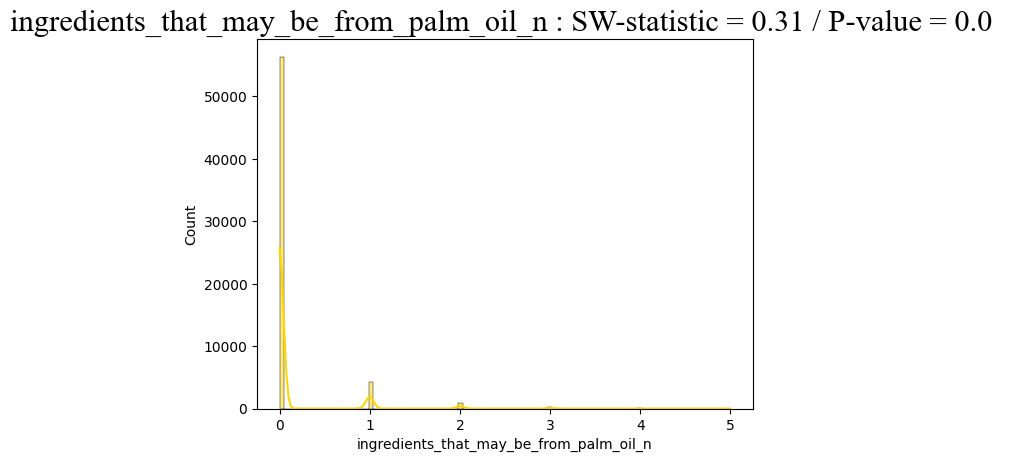

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


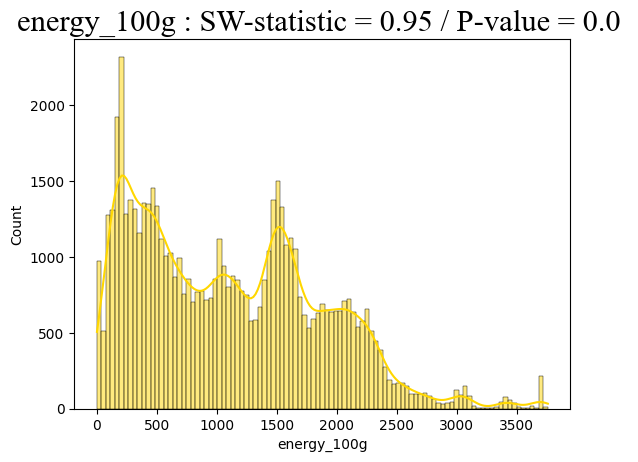

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


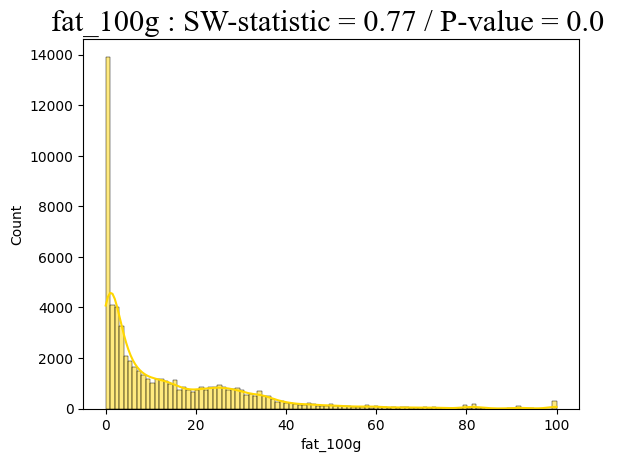

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


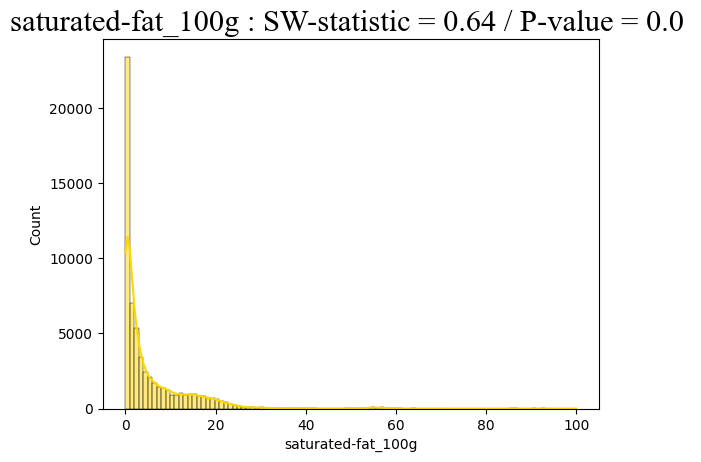

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


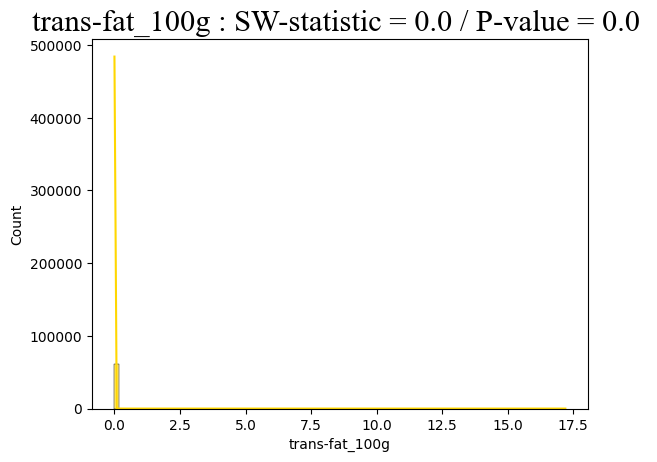

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


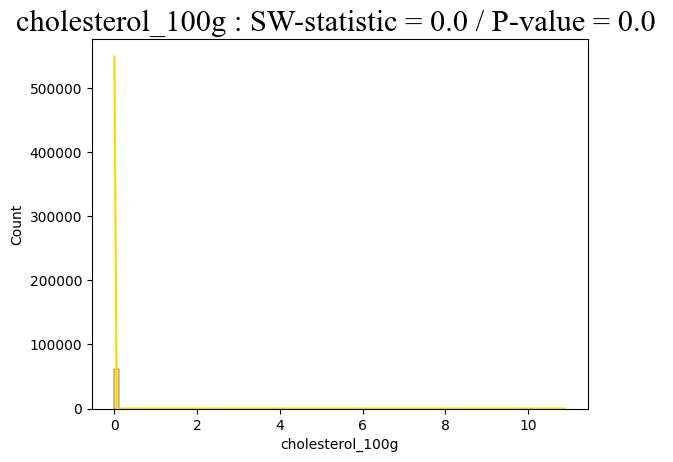

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


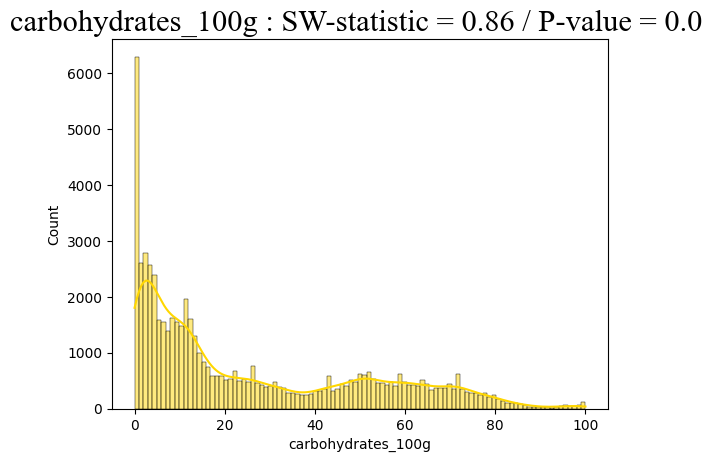

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


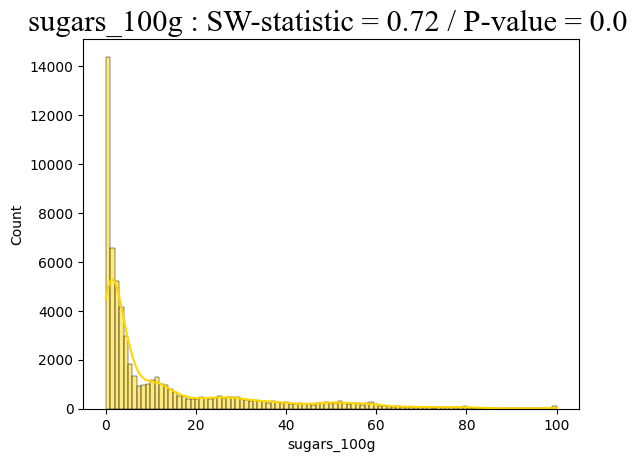

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


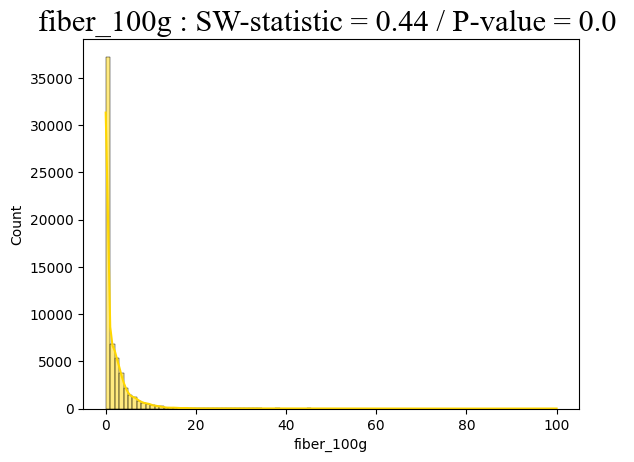

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


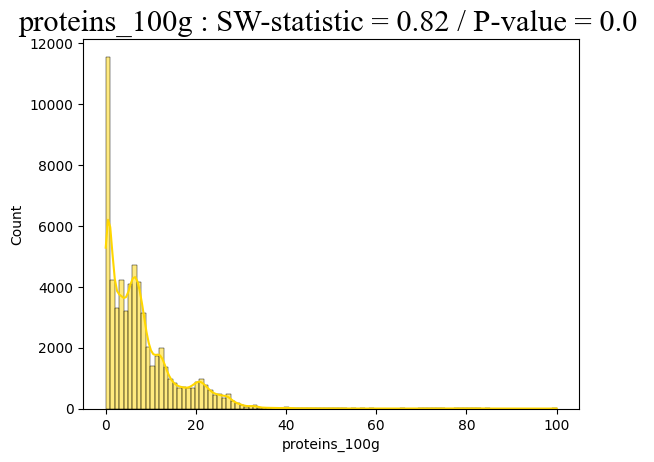

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


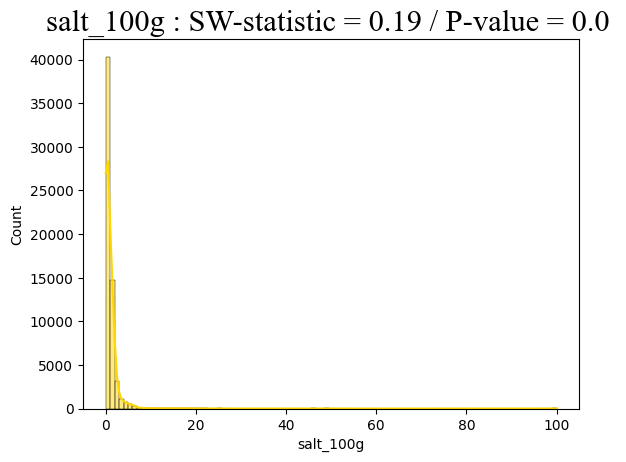

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


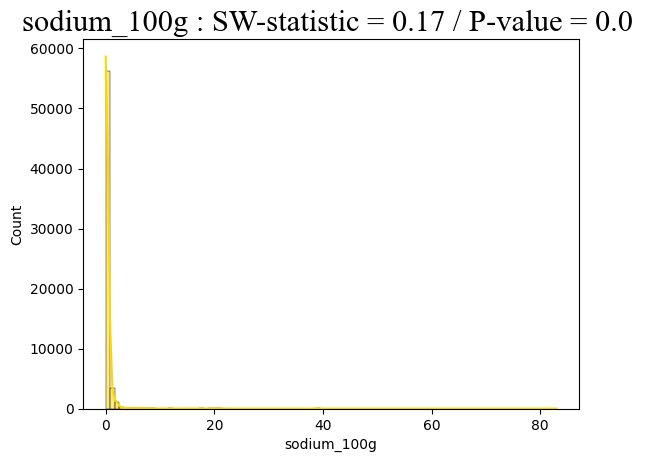

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


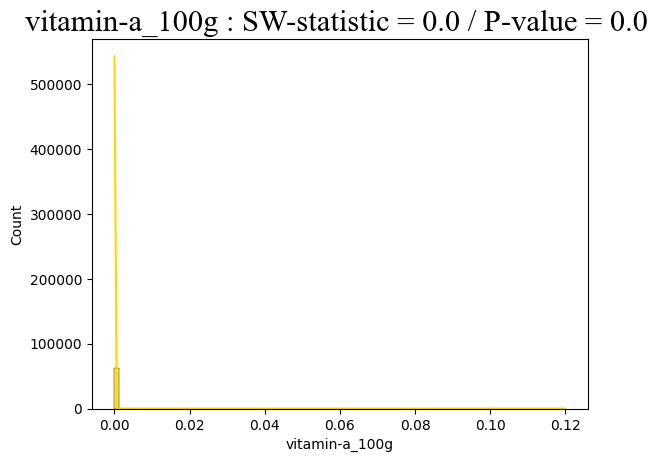

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


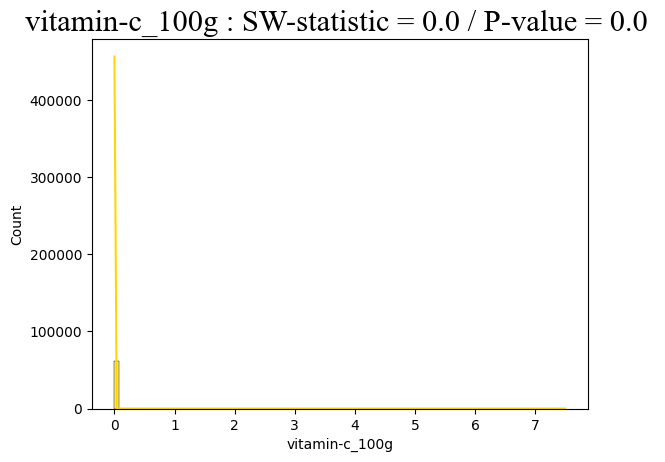

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


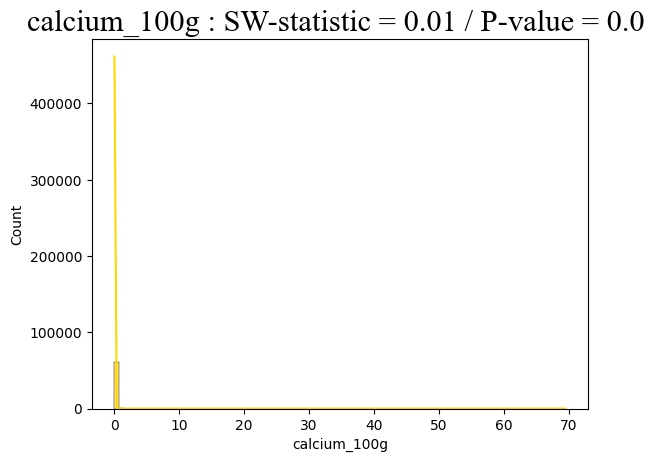

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


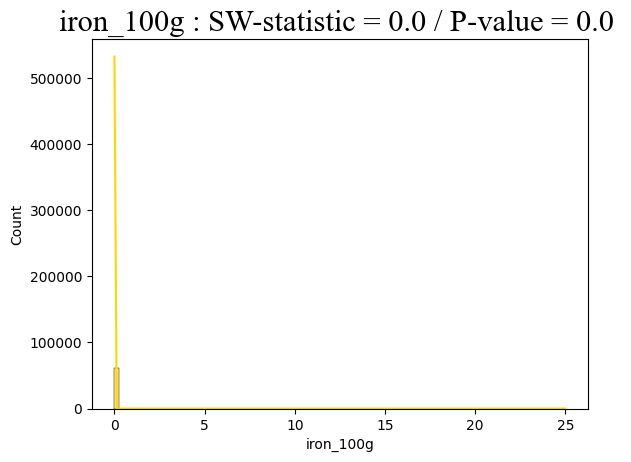

c:\Users\pierr\VSC_Projects\Projet3_OCR_DataScientist\env\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


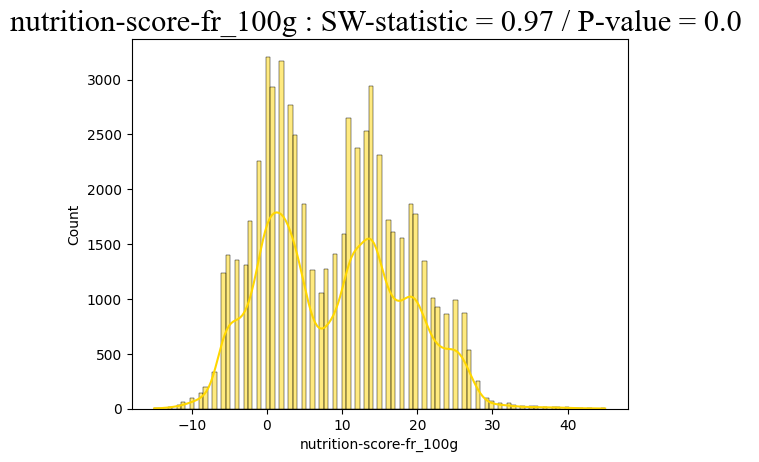

,Column,SW-statistic,P-value
0,additives_n,0.64575,0.0
1,ingredients_from_palm_oil_n,0.22780,0.0
2,ingredients_that_may_be_from_palm_oil_n,0.30616,0.0
3,energy_100g,0.94936,0.0
4,fat_100g,0.77444,0.0
5,saturated-fat_100g,0.64348,0.0
6,trans-fat_100g,0.00292,0.0
7,cholesterol_100g,0.00055,0.0
8,carbohydrates_100g,0.86016,0.0
9,sugars_100g,0.71868,0.0


In [36]:
# Initialiser une liste pour stocker les résultats du test de Shapiro-Wilk
shapiro_results = []

# POUR chaque colonne du df
for column in df_data_float.columns:
	
    # Effectuez le test de Shapiro-Wilk
    sw_statistic, p_value = shapiro(df_data_float[column])

    # Ajoutez les résultats à la liste shapiro_results
    shapiro_results.append({'Column': column, 'SW-statistic': sw_statistic, 'P-value': p_value})
    
    # Affichage Courbe histogramme
    sns.histplot(df_data[column], kde=True, color=colors1[0], bins=101)
    plt.title("{0} : SW-statistic = {1} / P-value = {2} ".format(column, round(sw_statistic, 2), round(p_value, 2)), fontdict=font_title)
    plt.show()

# Créez un DataFrame à partir de la liste shapiro_results
df_shapiro_results = pd.DataFrame(shapiro_results)

# Affichez les résultats
display(df_shapiro_results)

On veut savoir si ces données suivent la loi normale. On doit donc réaliser un test d'hypothèse pour chaque variable :

**Hypothèse nulle (H0) : la population est distribuée normalement selon la loi gaussienne.**

Hypothèse alternative (HA) : la population n'est pas distribuée normalement selon la loi gaussienne.

In [37]:
import pandas as pd

# Créez un DataFrame exemple
data = {'colonne1': [1, 2, 3],
        'colonne2': ['A', 'B', 'C'],
        'colonne3': [10.5, 20.0, 30.5]}

df = pd.DataFrame(data)

display(df)

# Boucle pour parcourir chaque ligne des trois colonnes
for index, row in df.iterrows():
    valeur_colonne1 = row['colonne1']
    valeur_colonne2 = row['colonne2']
    valeur_colonne3 = row['colonne3']
    
    # Vous pouvez analyser les valeurs ici
    print(f"Ligne {index + 1}: Colonne1={valeur_colonne1}, Colonne2={valeur_colonne2}, Colonne3={valeur_colonne3}")


,colonne1,colonne2,colonne3
0,1,A,10.5
1,2,B,20.0
2,3,C,30.5


Ligne 1: Colonne1=1, Colonne2=A, Colonne3=10.5
Ligne 2: Colonne1=2, Colonne2=B, Colonne3=20.0
Ligne 3: Colonne1=3, Colonne2=C, Colonne3=30.5


In [38]:
# POUR chaque variable
for index, row in df_shapiro_results.iterrows():
    
    # Affichage de la variable
    print("\n", row["Column"])
    
    # Affichage résultat test statistique
    p_value = row["P-value"]
    resultat_normalite(p_value, seuil_significativite)


 additives_n
p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : Les données ne suivent pas la loi normale

 ingredients_from_palm_oil_n
p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : Les données ne suivent pas la loi normale

 ingredients_that_may_be_from_palm_oil_n
p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : Les données ne suivent pas la loi normale

 energy_100g
p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : Les données ne suivent pas la loi normale

 fat_100g
p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : Les données ne suivent pas la loi normale

 saturated-fat_100g
p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : Les données ne suivent pas la loi normale

 trans-fat_100g
p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : Les données ne suivent pas la loi normale

 cholesterol_100g
p value = 0.0 < seuil de significativité (0.05) 
=> H0 rejettée : Les donnée

L'intégralité des données quantitatives de ce dataset ne suit pas la loi normal, nous allons donc effectuer le test pour variables non-paramétrique de Kruskall Wallis.

#### Test non-paramétrique de Kruskall-Wallis

On veut savoir si les valeurs des variables quantitatives du dataset sont influencées par les variables qualitatives relatives au Nutri-score et aux pnns des catégories d'aliment. On doit donc réaliser un test d'hypothèse pour chaque combinaison  :

**Hypothèse nulle (H0) : la valeur de la variable qualitative n'influence pas les valeurs de la variable quantitative.**

Hypothèse alternative (HA) : la valeur de la variable qualitative influence les valeurs de la variable quantitative.

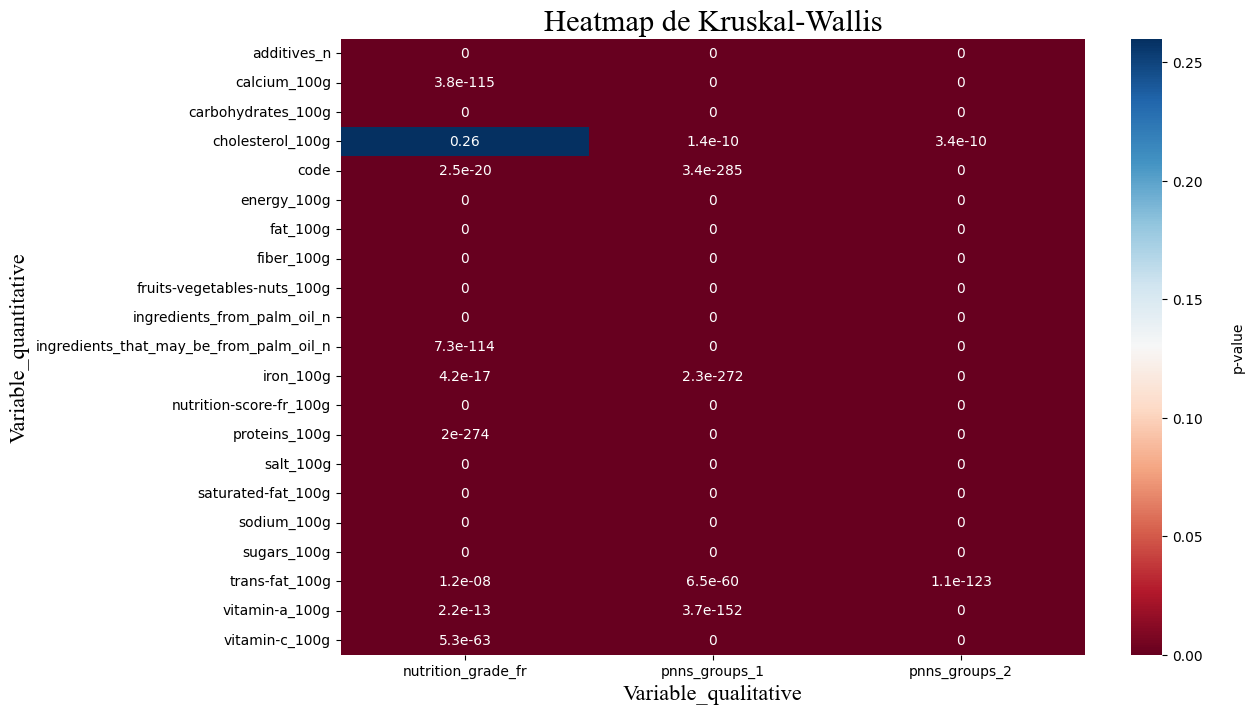

In [39]:
# Colonnes quantitatives
quantitative_cols = df_data.select_dtypes(include=['int64', 'float64'])

# Colonnes qualitatives d'intérêt
qualitative_cols = ['nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2']

# Liste vide pour stocker les résultats Kruskal-Wallis
kruskal_results = []

# Test de KW pour chaque combinaison de col quantitative et qualitative
for quan_col in quantitative_cols.columns:
    
    for qual_col in qualitative_cols:
        group_data = []
        
        for category in df_data[qual_col].unique():
            group_data.append(df_data[df_data[qual_col] == category][quan_col])
        
        # Test KW pour chaque ligne du tableau et stockage des résultats
        stat_kw, p_value = kruskal(*group_data)
        kruskal_results.append({'Variable_quantitative': quan_col, 'Variable_qualitative': qual_col, 'Kruskal-Stat': stat_kw, 'P-Value': p_value})

# Convertion dictionnaires en une DataFrame
kruskal_results_df = pd.DataFrame(kruskal_results)

# Pivot table des résultats pour créer la heatmap
pivot_kruskal_results = kruskal_results_df.pivot(index='Variable_quantitative', columns='Variable_qualitative', values='P-Value')

# Création d'une heatmap Kruskall-Wallis
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(pivot_kruskal_results, annot=True, cmap='RdBu', cbar=True)

# Ajout titre graphiqe, des axes et label de la color bar
plt.title('Heatmap de Kruskal-Wallis', fontdict=font_title)
plt.xlabel('Variable_qualitative', fontdict=font_axe)
plt.ylabel('Variable_quantitative', fontdict=font_axe)
cbar = heatmap.collections[0].colorbar
cbar.set_label('p-value', labelpad=20)
plt.show()

Pour toutes les combinaisons de variables quantitatives avec les variables qualitatives la p-value < 0.05, à l'exception de la combinaison du cholesterol avec le Nutri-score. Donc à l'exeption de cette dernière combinaison, l'hypothèse H0 est systématiquement rejettée. 

**Les valeurs des variables quantitatives du dataset sont influencées par les variables qualitatives relatives au Nutri-score et aux pnns des catégories d'aliment**, à l'exception de la quantité de cholestérol qui n'est pas influencé par le Nutri-score. 

## <span style='background:green'>3/ Analyses multi-variées</span>

### Analyse multivariée descriptive : l'Analyse en Composantes Principales (ACP)

Nous allons d'abord centré et réduire nos donnés grâce au Scaler de la librairie "sklearn". 

In [40]:
# Dataframe des valeurs quantitatives (et ses noms de colonne)
X = df_data_float
features = df_data_float.columns

# On instancie notre scaler
scaler = StandardScaler()

# Application du scaler sur les données (et transformation en df)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

# Affichage de la moyenne et ecart-type
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
mean,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Les données scalées ont bien été centrées (moyenne = 0) et réduites (ecart-type = 1)

#### Eboulis des valeurs propres

Nous allons étudier le nombre de composante utiles à étudier grâce au critère de Kaiser (100 / nombre de composante) et afficher le pourcentage d'inertie totale associé à chaque composante grâce au diagramme de l'éboulis des valeurs propres.

L'ACP a trouvé 19 composantes qui déterminent 100.0 % du dataframe.

Soit un seuil de Kaiser = 5.26, les composantes principales à conserver sont les composantes 1 à 8.


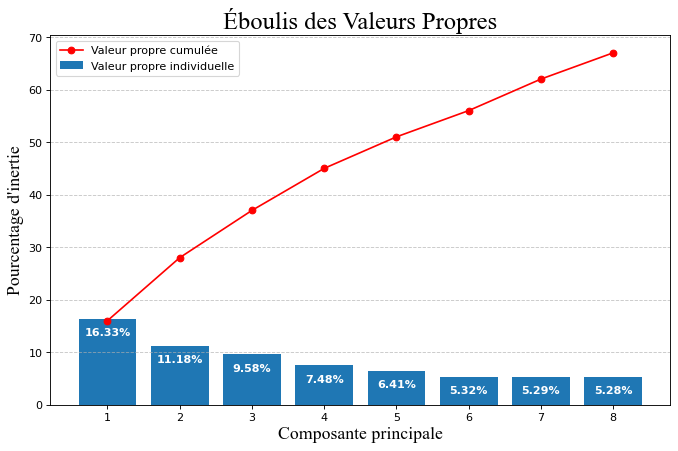

In [41]:
# Intanciation et entrainement de l'ACP
acp = PCA()
acp.fit(X_scaled)

# Fonction qui crée l'éboulis des valeur propres à partir du critère de Kaiser
composante_sup_kaiser_list, x_list = eboulis_valeurs_propres(acp, features)

Nous remarquons que seuls les 8 premières composantes principales respectent le critère de Kaiser. Elles représentent plus de 65% de l'inertie totale. 

#### Heatmap des composantes principales

Nous allons calculer les coefficents assiociés à chaque variable pour chacune des composantes principales. 

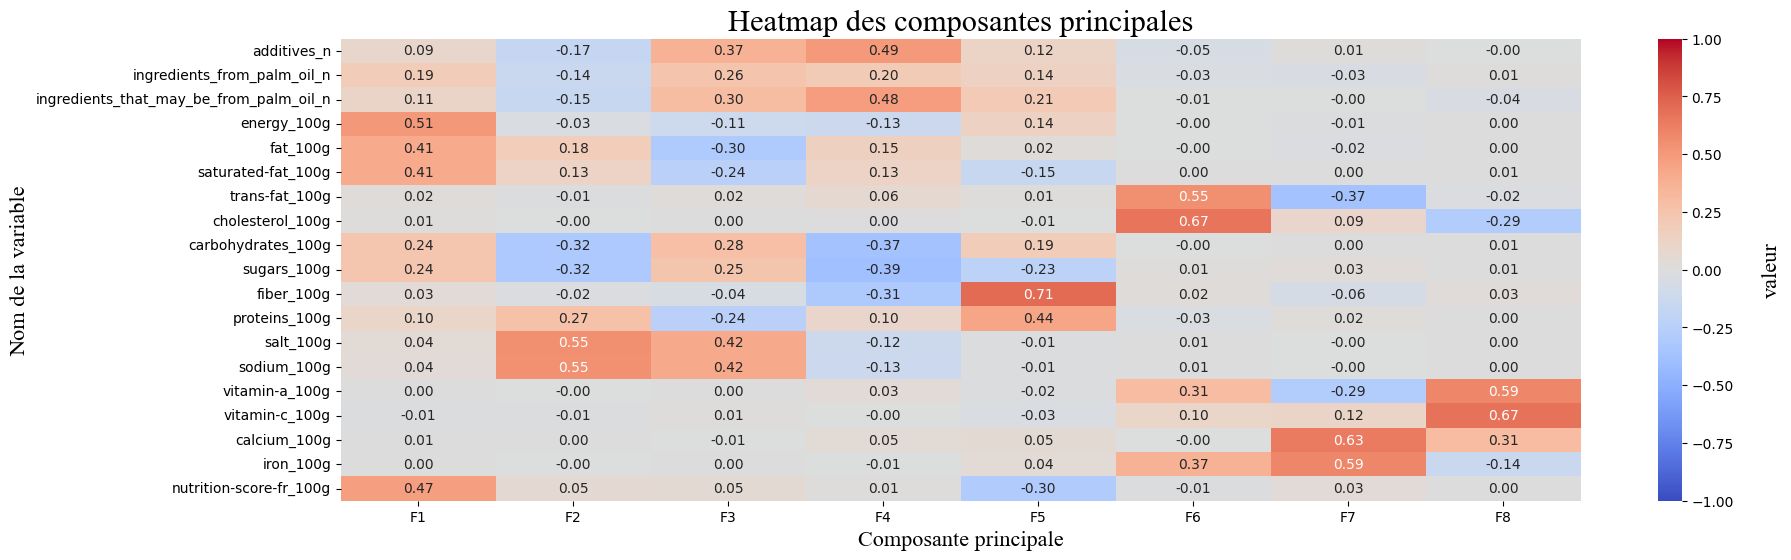

In [42]:
# Nombre de composante principales retenus (suite à Kaiser)
nb_composante_retenues = composante_sup_kaiser_list[-1]

# Intanciation et entrainement de l'ACP sur les composantes principales retenues
acp_retenue = PCA(n_components=nb_composante_retenues)
acp_retenue.fit(X_scaled)

# Séparation des composantes principales retenues (attribution nom de ligne/col)
pcs = pd.DataFrame(acp_retenue.components_)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]

# Heatmap des composantes principales retenues
fig, ax = plt.subplots(figsize=(20, 6))
heatmap = sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

# Ajout titre et label de la color bar
plt.title('Heatmap des composantes principales', fontdict=font_title)
plt.xlabel("Composante principale", fontdict=font_axe)
plt.ylabel("Nom de la variable", fontdict=font_axe)
cbar = heatmap.collections[0].colorbar
cbar.set_label('valeur', labelpad=20, fontdict=font_axe)
plt.show()

#### Plan factoriel et Cercle de corrélation

Une autre méthode d'affichage des composantes principales consiste à afficher leur plan factoriel et leur cercle de corrélation.

On crée d'abord le dataframe avec la projection des données sur les 8 plans factoriels retenus.

In [43]:
X_proj = acp_retenue.transform(X_scaled)

Plan factoriel et cercle de corrélation F1 et F2

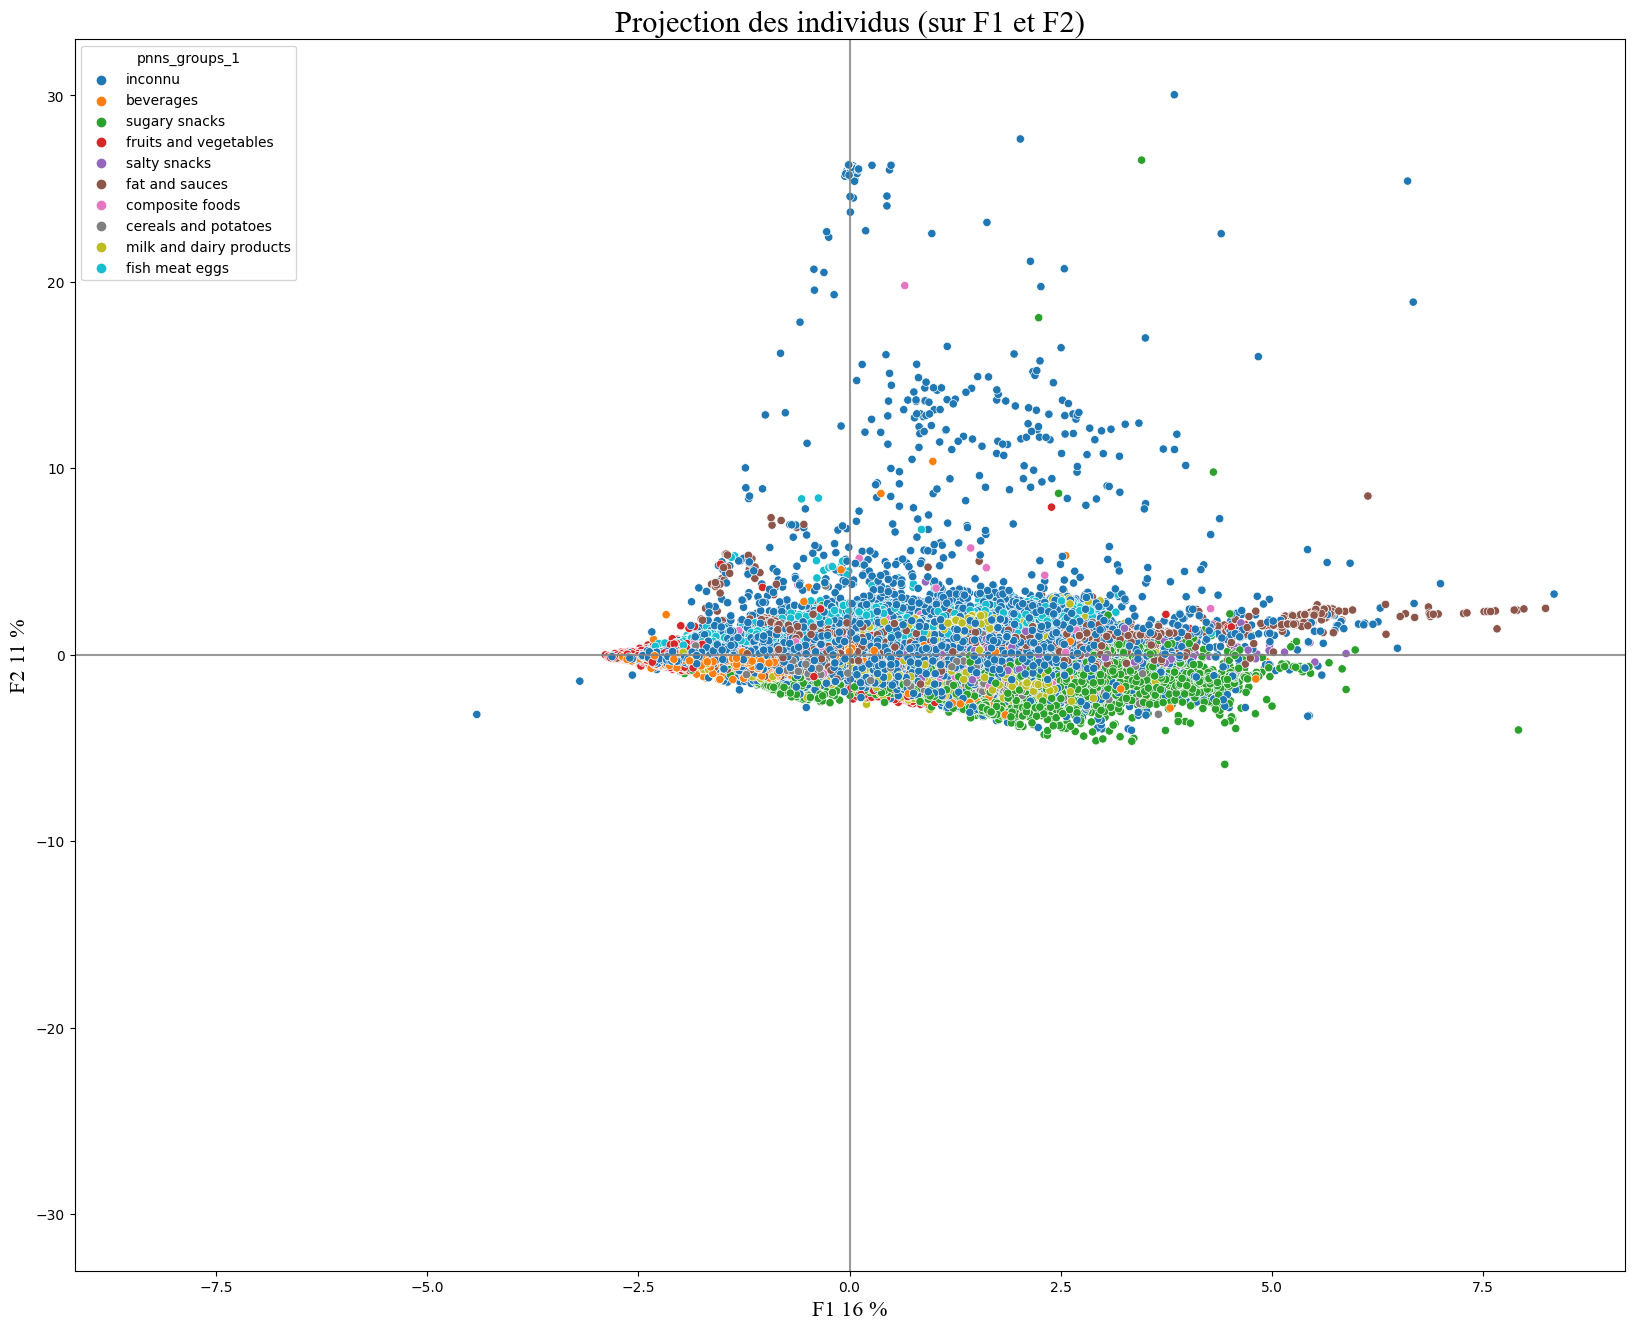

In [44]:
# Plan factoriel composante 1 et 2
x_y = [0, 1]
plan_factoriel(X_proj, x_y, acp_retenue, figsize=(20,16), clusters=df_data['pnns_groups_1'], marker="o")

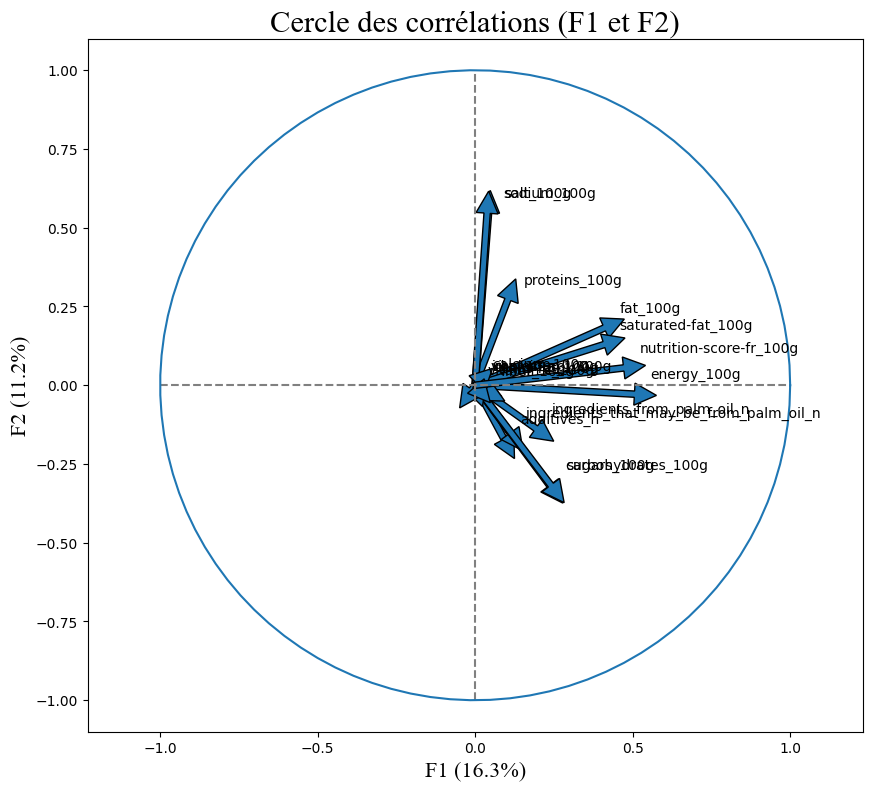

In [45]:
# Cercle des corrélations des composantes 1 et 2
correlation_graph(acp_retenue, (0, 1), features)

Plan factoriel et cercle de corrélation F3 et F4

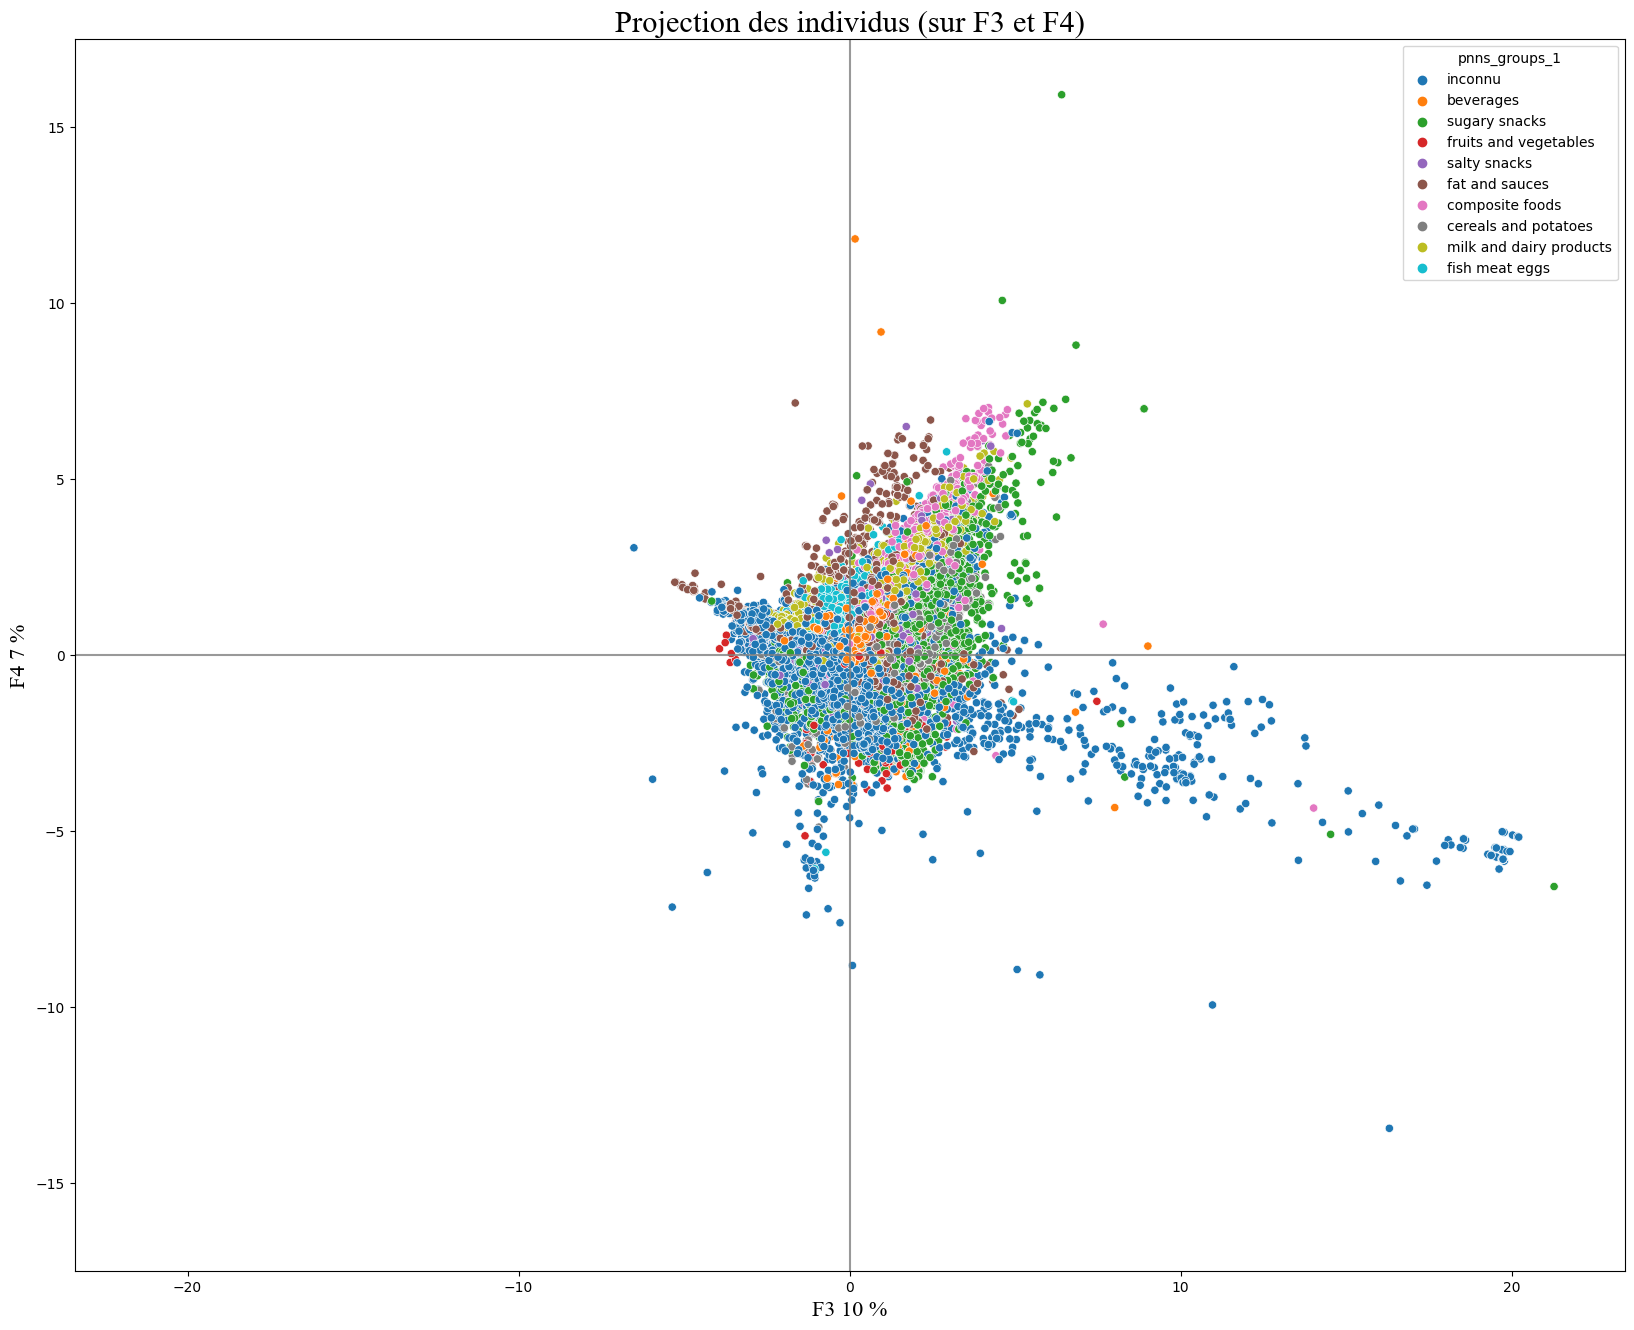

In [46]:
# Plan factoriel composante 3 et 4
x_y = [2, 3]
plan_factoriel(X_proj, x_y, acp_retenue, figsize=(20,16), clusters=df_data['pnns_groups_1'], marker="o")

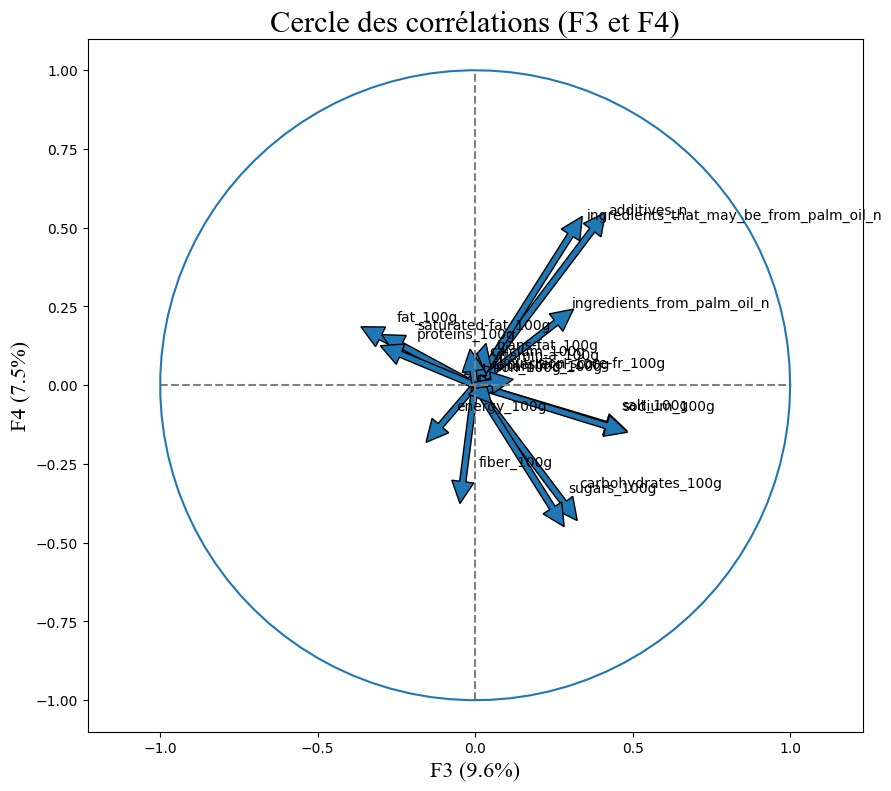

In [47]:
# Cercle des corrélations des composantes 3 et 4
correlation_graph(acp_retenue, (2, 3), features)

Nous remarquons que la 1ère composante principale (F1) semble corrélée à la quantité d'énergie, de lipides, d'acides gras saturés, au score nutritionnel. 

**F1 semble corrélé à l'apport calorique de l'aliment**.

La 2ème composante principale (F2) semble corrélée à la quantité de sel et de sodium. Elle est aussi corrélée négativement à la quantité de glucide et de sucre.

**F2 semble corrélé à la saveur salée de l'aliment**.

La 3ème composante principale (F3) semble corrélée à la quantité de sel, de sodium, du nombre d'additif et d'ingrédient qui pourraient provenir de l'huile de palme. Elle est aussi corrélée négativement à la quantité de lipide.

**F3 semble corrélé à l'apport d'élément ajoutés artificiellement par l'Homme dans l'aliment**.

La 4ème composante principale (F4) semble corrélée au nombre d'additif et d'ingrédient qui pourraient provenir de l'huile de palme. Elle est aussi corrélée négativement à la quantité de glucide, de sucre et de fibres.

**F4 semble corrélé à l'apport d'édulcorant (produit ayant un goût sucré mais qui n'apporte que peu de sucres)**.

<br><br>
*Nous nous arrêtons à la 4ème composante car les suivantes ne représentent qu'une petite partie de l'inertie globale (< 7%)*

AJOUTER LA NOUVELLE VARIABLE SYNTHETIQUE DE L'ACP DANS LE DF???::::

# <span style='background:red'>Méthode d’analyse multivariée explicative : ANOVA</span>

CE7 Vous avez expliqué, justifié et appliqué au minimum une méthode d’analyse multivariée explicative sur le jeu de données (par exemple une ANOVA, un test statistique).


Voir ANOVA faites plus haut?

# <span style='background:blue'>Conclusion</span>


ici...

Non independance des données?

Forte corrélation de certaines variables avec le Nutri-Score?